#### Initailization

In [69]:
desc = {
    "macro_area_ratio": "the ratio of total macros area in the layout",
    "mean_macro_edge_length": "the edge length of all macros calculated by average",
    "mean_macro_neighbor_distance": "the total near distances of macros calculated by average",
    "min_rudy": "the minimum value of the rudy map",
    "max_rudy": "the maximum value of the rudy map",
    "mean_rudy": "the average of the rudy map",
    "std_rudy": "the standard deviation of the rudy map",
    "PAR_rudy": "the Peak-to-Average Ratio of the rudy map",
    "high_density_rudy_ratio": "the ratio of hotspots area in the rudy map",
    "min_rudy_pin": "the minimum value of the rudy pin map",
    "max_rudy_pin": "the maximum value of the rudy pin map",
    "mean_rudy_pin": "the average of the rudy pin map",
    "std_rudy_pin": "the standard deviation of the rudy pin map",
    "PAR_rudy_pin": "the Peak-to-Average Ratio of the rudy pin map",
    "high_density_rudy_pin_ratio": "the ratio of hotspots area in the rudy pin map",
}

In [70]:
feat_func_list = []

In [71]:
train_design = ["RISCY-a", "RISCY-b", "RISCY-FPU-a", "RISCY-FPU-b"]
test_design_a = ["zero-riscy-a"]
test_design_b = ["zero-riscy-b"]

In [ ]:
api_key = "sk-your_api_key_here"

def encode_image(features):
    features_b64 = []
    for image in features:
        buff = BytesIO()
        image.save(buff, format="PNG")
        buff.seek(0)
        image_b64 = base64.b64encode(buff.read()).decode()
        features_b64.append(image_b64)
    return features_b64

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [73]:
import models
device = "cuda:4"
opt = {'task': 'congestion_gpdl', 'save_path': 'work_dir/congestion_gpdl/', 'pretrained': '/home/felixchaotw/CircuitNet/model/model_iters_20000.pth', 'max_iters': 200000, 'plot_roc': False, 'arg_file': None, 'cpu': False, 'dataroot': '../../training_set/congestion', 'ann_file_train': './files/train_N28.csv', 'ann_file_test': './files/test_N28.csv', 'dataset_type': 'CongestionDataset', 'batch_size': 16, 'aug_pipeline': ['Flip'], 'model_type': 'GPDL', 'in_channels': 3, 'out_channels': 1, 'lr': 0.0002, 'weight_decay': 0, 'loss_type': 'MSELoss', 'eval_metric': ['NRMS', 'SSIM', 'EMD'], 'ann_file': './files/test_N28.csv', 'test_mode': True}
model = models.__dict__["GPDL"](**opt)
model.init_weights(**opt)
model.to(device)

GPDL(
  (encoder): Encoder(
    (c1): conv(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c2): conv(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (

In [74]:
import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [75]:
import numpy as np
from PIL import Image
import requests, base64
import json
import argparse
from io import BytesIO
import cv2
import heapq

tile_size = 16
image_size = 256


def get_tiles_congestion(image_array):
    tiles = []
    for x in range(0, image_size, tile_size):
        for y in range(0, image_size, tile_size):
            tile = image_array[x:x+tile_size, y:y+tile_size]
            tiles.append(np.mean(tile))
            
    tiles = heapq.nlargest(20, tiles)
    return tiles

file_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/feature/zero-riscy-b/10176-zero-riscy-b-3-c5-u0.75-m1-p5-f1.npy'
label_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/label/zero-riscy-b/10176-zero-riscy-b-3-c5-u0.75-m1-p5-f1.npy'
numpy_image = np.load(file_path)
label_image = np.load(label_path).squeeze()
batch_image = numpy_image.transpose(2,0,1)
image_features = []
image_inferences = []

for i, image in enumerate(batch_image):
    image_features.append(image)
    image_inferences.append(Image.fromarray(np.uint8(image * 255)))
    
tiles = get_tiles_congestion(label_image)
image_inferences.append(Image.fromarray(np.uint8(label_image * 255)))
print(np.mean(tiles))

0.15229852198689037


In [76]:
base64_images = encode_image(image_inferences)

In [77]:
def macro_features(image):
    tiles_size = 2.25
    image_height, image_width = image.shape
    total_image_area = image_width * image_height
    
    image = np.uint8(image*255)
    
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    centroids = []
    total_macros_area = 0
    total_edge_length = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        total_macros_area += w * h
        total_edge_length += 2 * (w + h)
        centroid_x = x + w / 2
        centroid_y = y + h / 2
        centroids.append((centroid_x, centroid_y))
    
    neighbor_distances = []
    for i, (x1, y1) in enumerate(centroids):
        min_distance = float("inf")  
        for j, (x2, y2) in enumerate(centroids):
            if i != j: 
                distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                if distance < min_distance:
                    min_distance = distance
        neighbor_distances.append(min_distance)
    

    if neighbor_distances and num_macros > 1:
        mean_neighbor_distance = sum(neighbor_distances) / len(neighbor_distances)
    else:
        mean_neighbor_distance = 0.0
 
    
    return {
            "mean_macro_neighbor_distance": float(mean_neighbor_distance * tiles_size),
            "macro_area_ratio": total_macros_area / total_image_area,
            "mean_macro_edge_length": (total_edge_length / num_macros) * tiles_size,
        }

In [78]:
def rudy_features(image):
    total_area = image.shape[0] * image.shape[1]
    max_rudy = np.max(image)
    min_rudy = np.min(image)
    mean_rudy = np.mean(image)
    std_rudy = np.std(image)
    par_rudy = max_rudy / mean_rudy
    high_density_rudy_ratio = (image > mean_rudy).sum() /  total_area
    
    return {
        "mean_rudy": mean_rudy,
        "std_rudy": std_rudy,
        "PAR_rudy": par_rudy,
        "high_density_rudy_ratio": high_density_rudy_ratio,
    }

In [79]:
def rudy_pin_features(image):
    total_area = image.shape[0] * image.shape[1]
    max_rudy = np.max(image)
    min_rudy = np.min(image)
    mean_rudy = np.mean(image)
    std_rudy = np.std(image)
    par_rudy = max_rudy / mean_rudy
    high_density_rudy_ratio = (image > mean_rudy).sum() /  total_area
    
    return {
        "mean_rudy_pin": mean_rudy,
        "std_rudy_pin": std_rudy,
        "PAR_rudy_pin": par_rudy,
        "high_density_rudy_pin_ratio": high_density_rudy_ratio,
    }

In [80]:
def get_all_features(images):
    macro_feature = images[0]
    rudy_feature = images[1]
    rudy_pin_feature = images[2]
    
    mf = macro_features(macro_feature)
    rf = rudy_features(rudy_feature)
    rpf = rudy_pin_features(rudy_pin_feature)
    
    final_features = {**mf, **rf, **rpf}
    
    for feat_func in feat_func_list:
        feat = feat_func(images)
        final_features.update(feat)
        
    return final_features

#### Fitness Scoring

In [470]:
get_all_features(image_features)

{'mean_macro_neighbor_distance': 86.29562503334292,
 'macro_area_ratio': 0.5718231201171875,
 'mean_macro_edge_length': 392.7,
 'mean_rudy': np.float64(0.16759109363739882),
 'std_rudy': np.float64(0.10180513027100063),
 'PAR_rudy': np.float64(5.966904196971269),
 'high_density_rudy_ratio': np.float64(0.4022674560546875),
 'mean_rudy_pin': np.float64(0.0994746065198448),
 'std_rudy_pin': np.float64(0.07769547824745768),
 'PAR_rudy_pin': np.float64(10.052816844271748),
 'high_density_rudy_pin_ratio': np.float64(0.1454620361328125),
 'macro_spacing_std': np.float64(123.73596989365004),
 'macro_boundary_distance_var': np.float64(24077.164218750004),
 'pin_clustering_factor': np.float64(1.74778133797246e-05),
 'macro_diagonal_connectivity': np.float64(203264.4375),
 'rudy_gradation_smoothness': np.float64(0.09569972731248028),
 'macro_edge_proximity_to_pins': 139.5,
 'macro_cluster_compactness': 14.37886962195726,
 'pin_density_variance': np.float64(0.003624759987305908),
 'pin_neighborhoo

In [471]:
import pandas as pd
from tqdm import tqdm
import os
import torch


def dataset_setting(designs):
    df_list = []
    for design in designs:
        feature_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/feature/{design}/" 
        label_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/label/{design}/"

        labels = []
        ids = []

        for filename in tqdm(os.listdir(label_path)):
            file_path = os.path.join(label_path, filename)
            label_image = np.load(file_path).squeeze()
            label = float(np.mean(get_tiles_congestion(label_image)))
            ids.append(filename)
            labels.append(label)
            
        df = pd.DataFrame({"id": ids,})

        for filename in tqdm(os.listdir(feature_path)):
            file_path = os.path.join(feature_path, filename)
            numpy_image = np.load(file_path)
            batch_image = numpy_image.transpose(2,0,1)
            image_features = []
            for i, image in enumerate(batch_image):
                image_features.append(image)
            
            index = (df["id"] == filename)
            
            all_features = get_all_features(image_features)
            for key, value in all_features.items():
                df.loc[index, key] = value
            
            with torch.no_grad():
                input_image = torch.tensor(batch_image).unsqueeze(0).float().to(device)
                output_image = model(input_image)
                prediction = np.mean(get_tiles_congestion(output_image.cpu().numpy().squeeze()))
            
            df.loc[index, "prediction_gpdl"] = prediction
        
        df['label'] = labels
        df_list.append(df)
        
    return pd.concat(df_list)

In [472]:
train_df = dataset_setting(train_design)
test_df_a = dataset_setting(test_design_a)
test_df_b = dataset_setting(test_design_b)

100%|██████████| 1122/1122 [01:05<00:00, 17.01it/s]


In [473]:
train_df = train_df[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"] + list(new_feat_pool.keys())]

In [474]:
test_df_a = test_df_a[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"] + list(new_feat_pool.keys())]
test_df_b = test_df_b[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"] + list(new_feat_pool.keys())]

In [475]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

x = train_df.drop(columns=["id", "label", "prediction_gpdl"])
y = train_df["label"]
regressor = RandomForestRegressor(random_state=18, max_depth=10, n_estimators=1000)
regressor.fit(x, y)

RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=18)

Text(0, 0.5, 'Feature')

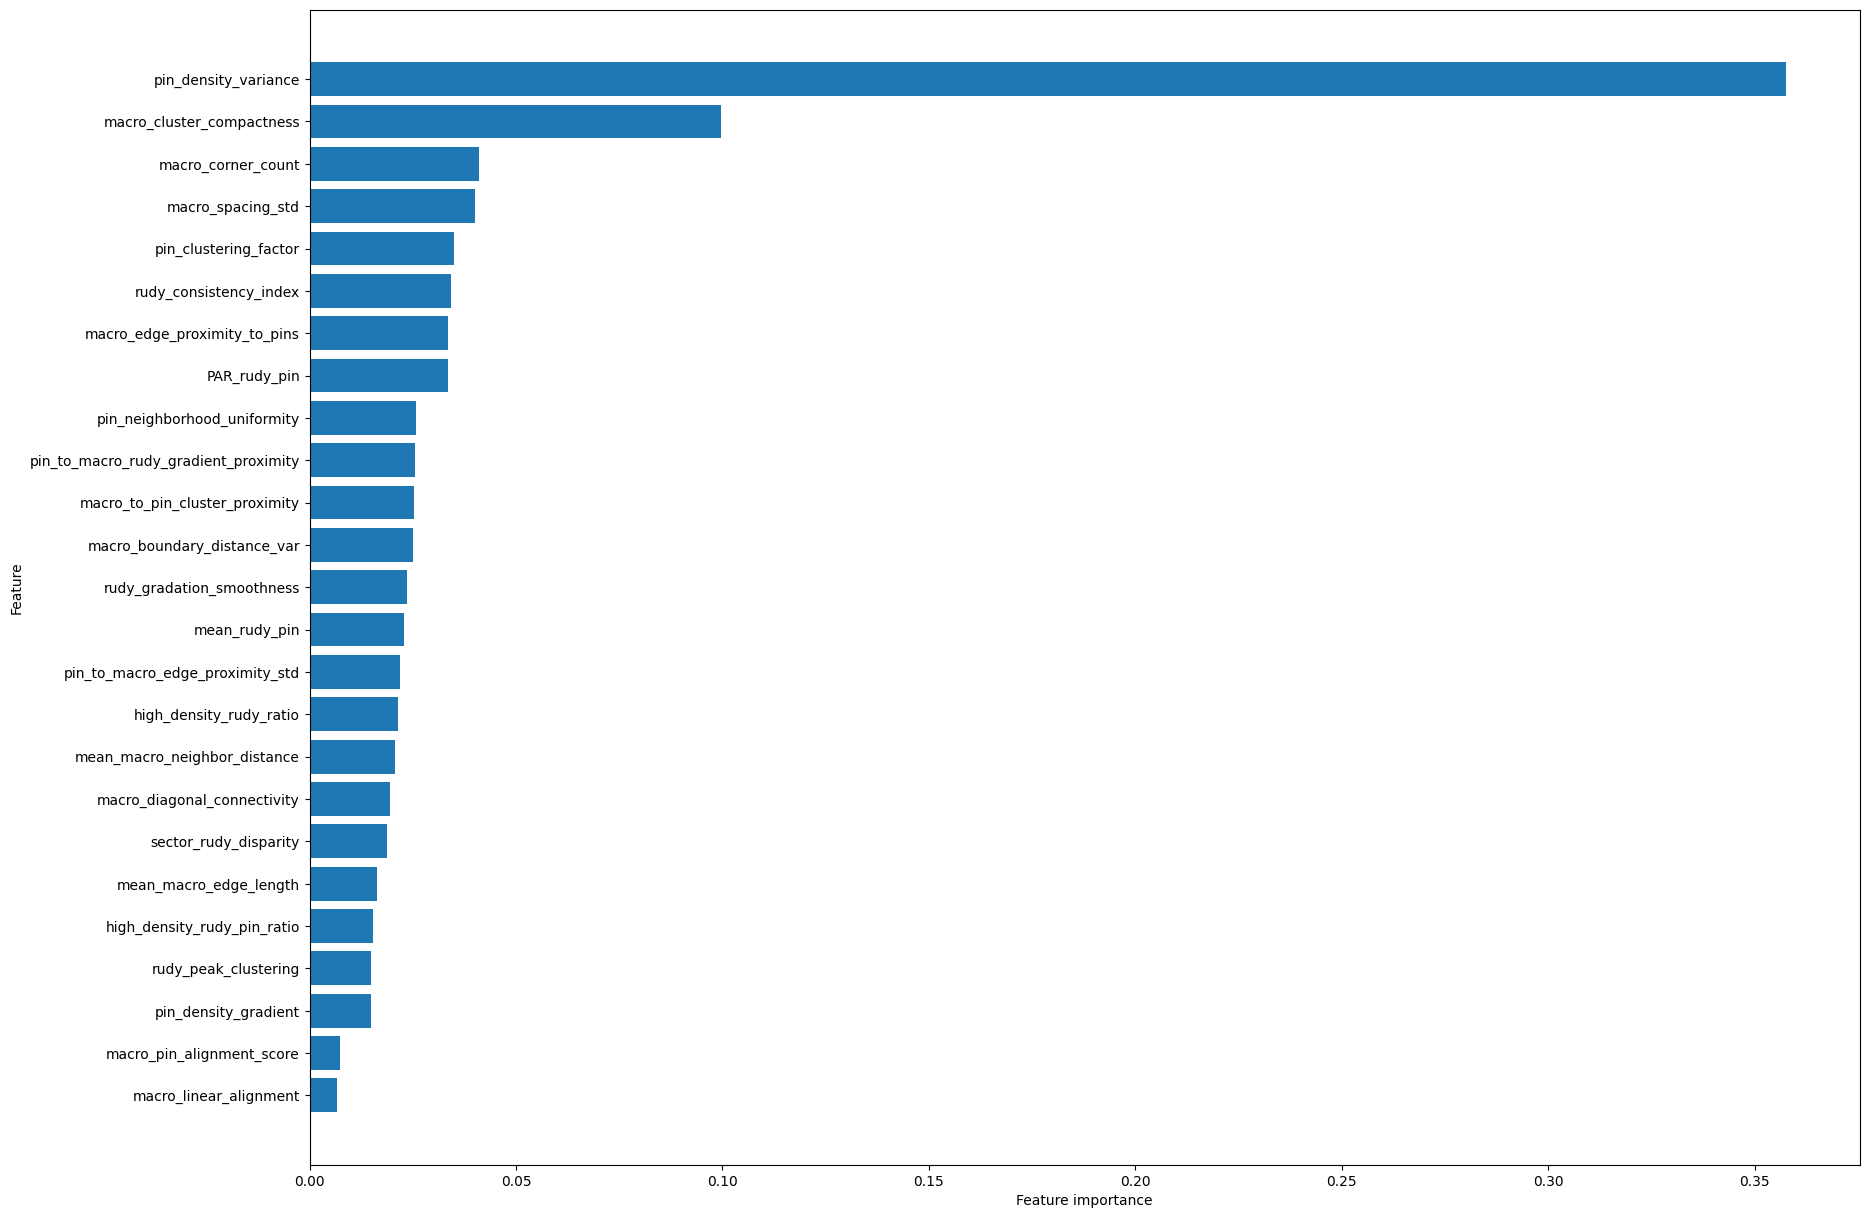

In [476]:
feature_importance = regressor.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15)) # Set plot size (denoted in inches)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis

In [477]:
y_hat_a = regressor.predict(test_df_a.drop(columns=["id", "label", "prediction_gpdl"]))
y_hat_b = regressor.predict(test_df_b.drop(columns=["id", "label", "prediction_gpdl"]))
test_df_a["prediction"] = y_hat_a
test_df_b["prediction"] = y_hat_b

In [478]:
from scipy import stats
from sklearn.metrics import ndcg_score

def evalute_corr(congestion_set, predicted, corr_metrics):
    x = np.array(list(congestion_set.values()))
    predicted = sorted(predicted.items(), key=lambda x: x[1])
    y = np.array([congestion_set[file_path] for file_path, _ in predicted])
    results = {}
    if "PLCC" in corr_metrics:
        results["PLCC"] = stats.pearsonr(x, y)
    if "SRCC" in corr_metrics:
        results["SRCC"] = stats.spearmanr(x, y)
    if "KRCC" in corr_metrics:
        results["KRCC"] = stats.kendalltau(x, y)
    
    return results


def evalute_ndcg(congestion_set, predicted):
    congestion_set = dict(sorted(congestion_set.items(), key=lambda x: x[0]))
    x = np.array(list(congestion_set.values()))
    predicted = dict(sorted(predicted.items(), key=lambda x: x[0]))
    y = np.array(list(predicted.values()))
    return ndcg_score([x], [y])

def evaluate_design(df):
    congestion_set = dict(zip(df["id"], df["label"]))
    congestion_set = dict(sorted(congestion_set.items(), key=lambda x: x[1]))
    predicted = dict(zip(df["id"], df["prediction"]))
    corr_metrics = ["PLCC", "SRCC", "KRCC"]
    results = evalute_corr(congestion_set, predicted, corr_metrics)
    results["NDCG"] = evalute_ndcg(congestion_set, predicted)
    return results

#### Baseline

In [825]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.1440677872814935), pvalue=np.float64(6.136830228930175e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.12987480849087346), pvalue=np.float64(3.85691144235756e-09)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08753846973362364), pvalue=np.float64(3.0610691006664493e-09)),
 'NDCG': np.float64(0.9597174164328586)}

In [826]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.16684860167978002), pvalue=np.float64(1.8872803874000822e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1477557449373694), pvalue=np.float64(6.658853690113137e-07)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09888424987077021), pvalue=np.float64(7.070526596401339e-07)),
 'NDCG': np.float64(0.9551973836885712)}

In [101]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.1424852398497009), pvalue=np.float64(9.945575098189869e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13780563123250592), pvalue=np.float64(4.0194304338346045e-10)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09319549415221656), pvalue=np.float64(2.765316358453054e-10)),
 'NDCG': np.float64(0.9575622155797455)}

In [102]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.13055921604252813), pvalue=np.float64(1.1483890112034805e-05)),
 'SRCC': SignificanceResult(statistic=np.float64(0.14136396322915543), pvalue=np.float64(1.9964976128417005e-06)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09295319893435126), pvalue=np.float64(3.1322436170843306e-06)),
 'NDCG': np.float64(0.9574970061843386)}

#### Stage 1.

In [91]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.08649899869908996), pvalue=np.float64(9.089138708955547e-05)),
 'SRCC': SignificanceResult(statistic=np.float64(0.10799761174978338), pvalue=np.float64(1.0003287664675104e-06)),
 'KRCC': SignificanceResult(statistic=np.float64(0.07199844897328461), pvalue=np.float64(1.0832094471205787e-06)),
 'NDCG': np.float64(0.9508102811104201)}

In [92]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.08106242004339176), pvalue=np.float64(0.006592959389750979)),
 'SRCC': SignificanceResult(statistic=np.float64(0.11006563989064824), pvalue=np.float64(0.000220834804209146)),
 'KRCC': SignificanceResult(statistic=np.float64(0.07120124060598831), pvalue=np.float64(0.00035560792871340764)),
 'NDCG': np.float64(0.9482617711615231)}

#### Stage 2.

In [124]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.11492179864327486), pvalue=np.float64(1.916871082641949e-07)),
 'SRCC': SignificanceResult(statistic=np.float64(0.116263773716575), pvalue=np.float64(1.3758572029735668e-07)),
 'KRCC': SignificanceResult(statistic=np.float64(0.07841515015253522), pvalue=np.float64(1.0936155507802135e-07)),
 'NDCG': np.float64(0.955547269301174)}

In [126]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.06048239918794246), pvalue=np.float64(0.04281286941589542)),
 'SRCC': SignificanceResult(statistic=np.float64(0.061217035918441604), pvalue=np.float64(0.040346903394361935)),
 'KRCC': SignificanceResult(statistic=np.float64(0.03749811125690882), pvalue=np.float64(0.060016677368795415)),
 'NDCG': np.float64(0.9472215029079386)}

#### Stage 3.

In [192]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.12158221019419038), pvalue=np.float64(3.5637685823571776e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.11457699520995515), pvalue=np.float64(2.0861072522749311e-07)),
 'KRCC': SignificanceResult(statistic=np.float64(0.077171737337081), pvalue=np.float64(1.7299893953532764e-07)),
 'NDCG': np.float64(0.9548941753877704)}

In [193]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.01249986266233186), pvalue=np.float64(0.6757655188126636)),
 'SRCC': SignificanceResult(statistic=np.float64(0.002552243052909621), pvalue=np.float64(0.9319469983138495)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.000795260248916458), pvalue=np.float64(0.9681845807460547)),
 'NDCG': np.float64(0.9436568898751014)}

#### Stage 4.

In [236]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.15332523936835998), pvalue=np.float64(3.2719845822531e-12)),
 'SRCC': SignificanceResult(statistic=np.float64(0.14705771411352941), pvalue=np.float64(2.4291706363333866e-11)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09901616340680715), pvalue=np.float64(2.006040679788891e-11)),
 'NDCG': np.float64(0.9545436011844779)}

In [237]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.011194661762888136), pvalue=np.float64(0.7079779371274357)),
 'SRCC': SignificanceResult(statistic=np.float64(0.029953475191777913), pvalue=np.float64(0.3161329629873302)),
 'KRCC': SignificanceResult(statistic=np.float64(0.019471151934470556), pvalue=np.float64(0.32879130137346946)),
 'NDCG': np.float64(0.9430314091296831)}

#### Stage 5.

In [272]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.18486151442154536), pvalue=np.float64(3.7271822723408365e-17)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1729146389525253), pvalue=np.float64(3.594757361317978e-15)),
 'KRCC': SignificanceResult(statistic=np.float64(0.11712939123641111), pvalue=np.float64(2.15212887455019e-15)),
 'NDCG': np.float64(0.9590013777522316)}

In [273]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.0025506423330742415), pvalue=np.float64(0.9319895764896465)),
 'SRCC': SignificanceResult(statistic=np.float64(-0.0033173624686513646), pvalue=np.float64(0.9116197488602444)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.0016923138096942225), pvalue=np.float64(0.9323600583851215)),
 'NDCG': np.float64(0.9443737844944227)}

#### Stage 6

In [322]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14887139981342434), pvalue=np.float64(1.3717363391472461e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13808540919669185), pvalue=np.float64(3.7022694791263173e-10)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09325116219026855), pvalue=np.float64(2.6987369793501594e-10)),
 'NDCG': np.float64(0.9578952759802737)}

In [323]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.03558043756108483), pvalue=np.float64(0.2337083550504899)),
 'SRCC': SignificanceResult(statistic=np.float64(0.026187246630589186), pvalue=np.float64(0.3808411053417259)),
 'KRCC': SignificanceResult(statistic=np.float64(0.015537794743329754), pvalue=np.float64(0.4358155327148556)),
 'NDCG': np.float64(0.9453266196352341)}

#### Stage 7

In [359]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.19513018009287456), pvalue=np.float64(5.691210910947871e-19)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1886165233051777), pvalue=np.float64(8.30208566034678e-18)),
 'KRCC': SignificanceResult(statistic=np.float64(0.12766984630342632), pvalue=np.float64(5.330319333491061e-18)),
 'NDCG': np.float64(0.9587084902943803)}

In [360]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(-0.019880558710830148), pvalue=np.float64(0.5058918830761372)),
 'SRCC': SignificanceResult(statistic=np.float64(-0.013324702186238433), pvalue=np.float64(0.6557055344399361)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.009123225575569605), pvalue=np.float64(0.6472657002675055)),
 'NDCG': np.float64(0.9423789475885137)}

#### Stage 8

In [437]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.19115419531407127), pvalue=np.float64(2.955607317074353e-18)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1791347889737998), pvalue=np.float64(3.465029783295783e-16)),
 'KRCC': SignificanceResult(statistic=np.float64(0.12125506471169475), pvalue=np.float64(2.1817308807428052e-16)),
 'NDCG': np.float64(0.9603128649387445)}

In [438]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.01698812984714948), pvalue=np.float64(0.5697323693928426)),
 'SRCC': SignificanceResult(statistic=np.float64(-0.007677448244604918), pvalue=np.float64(0.7972690925765615)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.003755218895383514), pvalue=np.float64(0.850611442331823)),
 'NDCG': np.float64(0.9475486945584475)}

#### Stage 9

In [370]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.15962486945995827), pvalue=np.float64(4.0060189730176745e-13)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1605791757989239), pvalue=np.float64(2.892619985408547e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10856467162336156), pvalue=np.float64(1.9493009630003727e-13)),
 'NDCG': np.float64(0.9546248728024769)}

In [371]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(-0.06005101505509046), pvalue=np.float64(0.04431934247484312)),
 'SRCC': SignificanceResult(statistic=np.float64(-0.08048141682780152), pvalue=np.float64(0.006992558488855497)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.05385979561811603), pvalue=np.float64(0.006907503567783921)),
 'NDCG': np.float64(0.9450113141225648)}

#### Stage 10

In [405]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14228674434383598), pvalue=np.float64(1.0562509114297515e-10)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13941466731080687), pvalue=np.float64(2.499696138504226e-10)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09470476983905698), pvalue=np.float64(1.4211704436751063e-10)),
 'NDCG': np.float64(0.9549664197621537)}

In [406]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(-0.0035617366308346547), pvalue=np.float64(0.9051388669124685)),
 'SRCC': SignificanceResult(statistic=np.float64(-0.020723371997561794), pvalue=np.float64(0.4880232059175057)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.014185852320171777), pvalue=np.float64(0.47679070798574963)),
 'NDCG': np.float64(0.9458028781148465)}

#### Stage 11

In [438]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.13763302834225488), pvalue=np.float64(4.228154394265886e-10)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13270997461272996), pvalue=np.float64(1.7448595304914651e-09)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08977766857457668), pvalue=np.float64(1.2023313140377907e-09)),
 'NDCG': np.float64(0.9545439100272489)}

In [439]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(-0.019052168772135815), pvalue=np.float64(0.5237841829718719)),
 'SRCC': SignificanceResult(statistic=np.float64(-0.02885638950590088), pvalue=np.float64(0.33419178509451997)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.02047636088910096), pvalue=np.float64(0.30443629563043206)),
 'NDCG': np.float64(0.9427576638179417)}

#### Stage 12

In [475]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14744265193027772), pvalue=np.float64(2.1529697336529358e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.14107528327940352), pvalue=np.float64(1.5222999806069971e-10)),
 'KRCC': SignificanceResult(statistic=np.float64(0.0956093754574017), pvalue=np.float64(9.489487435038506e-11)),
 'NDCG': np.float64(0.9553584923280912)}

In [476]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(-0.020380819362867605), pvalue=np.float64(0.49524446584021287)),
 'SRCC': SignificanceResult(statistic=np.float64(-0.03369882324725188), pvalue=np.float64(0.25938455936436633)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.024424032764722256), pvalue=np.float64(0.22059144274321507)),
 'NDCG': np.float64(0.9425415676179754)}

#### Stage 13

In [554]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14558193797617258), pvalue=np.float64(3.847273422064755e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1364729558339483), pvalue=np.float64(5.932157259632411e-10)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09255579161149852), pvalue=np.float64(3.6554374524863544e-10)),
 'NDCG': np.float64(0.9555285765079923)}

In [555]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(-0.031056310511023533), pvalue=np.float64(0.29863656032435565)),
 'SRCC': SignificanceResult(statistic=np.float64(-0.044949480156967196), pvalue=np.float64(0.132395526337161)),
 'KRCC': SignificanceResult(statistic=np.float64(-0.030803610481530082), pvalue=np.float64(0.12236640836597484)),
 'NDCG': np.float64(0.9435047340434057)}

#### Genetic Algorithm

In [439]:
feat_importances = feature_importance[sorted_idx][-20:]
feat_pool = list(x.columns[sorted_idx])[-20:]

In [440]:
def sigmoid(x, shift=0):
    return 1 / (1 + np.exp(-(x-shift)))

In [441]:
feat_importances = sigmoid((1-feat_importances), shift=1)

In [442]:
feat_importances = {feat: imp for feat, imp in zip(feat_pool, feat_importances)}
feat_pool = {feat: desc[feat] for feat in feat_pool}

In [443]:
import re
import requests
from prompt import CROSS_OVER_PROMPT, MUTATION_PROMPT, DEDUPLICATION_PROMPT, CODE_GEN_PROMPT

def prompt_selection(task_id, desc, feat_pool, feat_importances):
    if task_id == 0:
        prompts = [CROSS_OVER_PROMPT.format(existing_features=desc, feat_pool=feat_pool)]
    else:
        pd = np.random.uniform(0, 1, len(feat_importances))
        prompts = []
        for i, (feat, imp) in enumerate(feat_importances.items()):
            if pd[i] < imp:
                feat = {feat: desc[feat]}
                mutated_prompt = MUTATION_PROMPT.format(existing_features=desc, feature=feat)
                prompts.append(mutated_prompt)
    return prompts

def mllm_single_inference(prompt, type="json"):
    payload = {
    "model": "gpt-4o",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[0]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[1]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[2]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[3]}"
            }
            },
            {
            "type": "text",
            "text": prompt,
            }
        ]
        }
    ],
    "max_tokens": 2000,
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response = response.json()['choices'][0]['message']['content'] 
    pattern = r"```json([\s\S]*?)```" if type == "json" else r"```python([\s\S]*?)```"
    response = re.search(pattern, response).group(1).strip()
    print(response)
    return response

def feat_extractor(task_id, responses):
    if task_id == 0:
        new_feat = json.loads(responses[0])
    else:
        new_feat = {}
        for response in responses:
            new_feat.update(json.loads(response))
            
    return new_feat

def featgen_inference(prompts):
    responses = []
    for prompt in prompts:
        response = mllm_single_inference(prompt)
        responses.append(response)
    return responses

def deduplicator(feat_pool, new_feat):
    prompt = DEDUPLICATION_PROMPT.format(feat_pool=feat_pool, new_feat_pool=new_feat)
    response = mllm_single_inference(prompt)
    response = json.loads(response)
    dup_feat = [r["feature"] for r in response]
    no_dup_feat = {k: v for k, v in new_feat.items() if k not in dup_feat}
    return no_dup_feat

def code_gen(new_feats):
    responses = []
    for new_feat, definition in new_feats.items():
        prompt = CODE_GEN_PROMPT.format(feature={new_feat: definition}, feature_name=new_feat)
        response = mllm_single_inference(prompt, type="python")
        responses.append(response)
    return responses

In [444]:
task_ids ={0: "cross-over", 1: "mutation"}
task_prob =[1, 0.0] 

def genetic_instruct(feat_pool, feat_importances):
    task_id = np.random.choice(list(task_ids.keys()), p=task_prob)
    print(f"Task: {task_ids[task_id]}")
    prompts = prompt_selection(task_id, desc, feat_pool, feat_importances)
    responses = featgen_inference(prompts)
    new_feats = feat_extractor(task_id, responses)
    no_dup_feat = deduplicator(desc, new_feats)
    return no_dup_feat

In [445]:
new_feat_pool = genetic_instruct(feat_pool, feat_importances)

Task: cross-over
{
  "macro_density_ratio": "the ratio of macro areas to the total layout area, indicating potential congestion regions",
  "pin_cluster_density_peak": "maximum density of pin clusters within the layout, identifying critical congestion hotspots",
  "rudy_pin_spatial_variability": "measure of spatial variability in RUDY pin values, indicating potential routing difficulty",
  "macro_linear_alignment": "degree of linear alignment of macros, reflecting potential for straightforward routing paths",
  "rudy_peak_clustering": "measure of clustering of RUDY peaks, indicating concentrated demand areas",
  "macro_pin_alignment_score": "score reflecting alignment between macros and pin clusters, affecting routing efficiency",
  "macro_edge_gradient_proximity": "average distance from macro edges to significant RUDY gradient changes, indicating potential routing challenges",
  "pin_density_gradient": "gradient of pin density across the layout, indicating areas of rapid congestion ch

In [447]:
new_feat_pool

{'macro_linear_alignment': 'degree of linear alignment of macros, reflecting potential for straightforward routing paths',
 'rudy_peak_clustering': 'measure of clustering of RUDY peaks, indicating concentrated demand areas',
 'macro_pin_alignment_score': 'score reflecting alignment between macros and pin clusters, affecting routing efficiency',
 'pin_density_gradient': 'gradient of pin density across the layout, indicating areas of rapid congestion change',
 'macro_to_pin_cluster_proximity': 'average proximity distance from macros to pin clusters, affecting potential routing efficiency'}

In [462]:
error_code = {
 'macro_linear_alignment': 'degree of linear alignment of macros, reflecting potential for straightforward routing paths',
}
code_feat = code_gen(error_code)
# code_feat = code_gen(new_feat_pool)

import numpy as np
import cv2

def macro_linear_alignment(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Initialize alignment score
    alignment_score = 0
    
    for contour in contours:
        # Fit a bounding rectangle around each macro
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calculate aspect ratio of the rectangle
        aspect_ratio = w / float(h)
        
        # Check if the rectangle is linear (either vertical or horizontal)
        if aspect_ratio > 1.5 or aspect_ratio < 0.67:
            alignment_score += 1

    

#### Stage 1 Function

In [102]:
import cv2
import numpy as np

def macro_perimeter_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_perimeter = 2 * (image_width + image_height) * tiles_size

    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total perimeter of macros
    macro_perimeter = sum(cv2.arcLength(contour, True) for contour in contours) * tiles_size

    # Calculate the macro perimeter ratio
    macro_perimeter_ratio = macro_perimeter / total_image_perimeter

    return {"macro_perimeter_ratio": macro_perimeter_ratio}
import cv2
import numpy as np
from scipy.stats import entropy

def macro_orientation_diversity(images):
    tiles_size = 2.25
    macro_image = images[0]  # scaled to [0-255]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    orientations = []
    
    for contour in contours:
        rect = cv2.minAreaRect(contour)
        angle = rect[-1]
        
        # Normalize the angle to [0, 90) range
        if angle < -45:
            angle += 90
        orientations.append(angle)
    
    # Calculate diversity index
    hist, _ = np.histogram(orientations, bins=10, range=(0, 90))
    hist = hist / np.sum(hist)  # Normalize the histogram
    diversity_index = entropy(hist)
    
    return {"macro_orientation_diversity": diversity_index}


def macro_spacing_std(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro_image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Extract the bounding boxes of the macros
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    
    # Calculate the center of each macro
    macro_centers = [(x + w / 2, y + h / 2) for (x, y, w, h) in bounding_boxes]
    
    # Function to calculate Euclidean distance
    def euclidean_distance(pt1, pt2):
        return np.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)
    
    # Calculate all pairwise distances between macro centers
    distances = []
    for i in range(len(macro_centers)):
        for j in range(i + 1, len(macro_centers)):
            dist = euclidean_distance(macro_centers[i], macro_centers[j])
            distances.append(dist * tiles_size)  # Convert to micrometers
    
    # Compute the standard deviation of the distances
    if len(distances) > 1:
        spacing_std = np.std(distances)
    else:
        spacing_std = 0.0  # No meaningful spacing if less than two macros
    
    return {"macro_spacing_std": spacing_std}


def overlapping_macro_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]

    # Convert macro image to 0-255 scale
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the macro image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Threshold for identifying high RUDY values
    high_rudy_threshold = 0.5
    high_rudy_mask = (rudy_image >= high_rudy_threshold).astype(np.uint8)

    # Calculate overlapping area
    overlap_area = 0
    for contour in contours:
        # Create a mask for this macro
        macro_mask = np.zeros_like(macro_image)
        cv2.drawContours(macro_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # Calculate overlap between macro and high RUDY areas
        overlap = cv2.bitwise_and(macro_mask, macro_mask, mask=high_rudy_mask)
        overlap_area += cv2.countNonZero(overlap)
    
    # Calculate density
    image_height, image_width = macro_image.shape
    total_area_um2 = image_height * image_width * (tiles_size ** 2)
    overlap_area_um2 = overlap_area * (tiles_size ** 2)
    overlapping_density = overlap_area_um2 / total_area_um2

    return {"overlapping_macro_density": overlapping_density}


def macro_centroid_clustering(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute centroids
    centroids = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            centroids.append((cx, cy))
    
    if len(centroids) < 2:
        return {"macro_centroid_clustering": 0}
    
    # Calculate the average distance between each centroid and the mean centroid
    centroids = np.array(centroids)
    mean_centroid = np.mean(centroids, axis=0)
    
    # Compute the average distance to the mean centroid
    distances = np.linalg.norm(centroids - mean_centroid, axis=1)
    average_distance = np.mean(distances)
    
    # Convert to micrometers
    average_distance_um = average_distance * tiles_size
    
    return {"macro_centroid_clustering": average_distance_um}


def pin_distribution_evenness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to uint8 format and binary image
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours to determine the number of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute pin distribution evenness
    image_height, image_width = rudy_pin_image.shape
    total_pixels = image_height * image_width
    
    # Calculate the number of white pixels in the RUDY pin image
    num_pin_pixels = np.sum(rudy_pin_image > 0.5)
    
    # Calculate pin distribution evenness
    evenness = num_pin_pixels / total_pixels
    
    return {"pin_distribution_evenness": evenness}


def macro_boundary_distance_var(images):
    tiles_size = 2.25  # size in micrometers
    macro_image = images[0]

    # Convert the macro image to uint8
    macro_image = np.uint8(macro_image * 255)

    # Threshold the image to get binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate distances from macro contours to image boundaries
    distances = []
    for contour in contours:
        # Calculate bounding rect for each macro
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calculate distances to each boundary (top, bottom, left, right)
        top_dist = y
        bottom_dist = macro_image.shape[0] - (y + h)
        left_dist = x
        right_dist = macro_image.shape[1] - (x + w)
        
        # Convert pixel distances to micrometers
        top_dist_um = top_dist * tiles_size
        bottom_dist_um = bottom_dist * tiles_size
        left_dist_um = left_dist * tiles_size
        right_dist_um = right_dist * tiles_size
        
        # Collect all boundary distances for the current macro
        distances.extend([top_dist_um, bottom_dist_um, left_dist_um, right_dist_um])

    # Calculate the variance of the distances
    feature_value = np.var(distances)

    return {"macro_boundary_distance_var": feature_value}


def rudy_pin_correlation(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to uint8
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute rudy_pin_correlation
    rudy_flat = rudy_image.flatten()
    rudy_pin_flat = rudy_pin_image.flatten()
    
    # Calculate correlation
    correlation = np.corrcoef(rudy_flat, rudy_pin_flat)[0, 1]
    
    return {"rudy_pin_correlation": correlation}

In [103]:
new_feat_func_list = [macro_perimeter_ratio, macro_orientation_diversity, macro_spacing_std, overlapping_macro_density, macro_centroid_clustering, pin_distribution_evenness, macro_boundary_distance_var, rudy_pin_correlation]

In [111]:
new_feat_func_list[7](image_features)

{'rudy_pin_correlation': np.float64(0.5816007018018947)}

In [112]:
feat_func_list = new_feat_func_list

In [113]:
desc.update(new_feat_pool)

#### Stage 2 Function

In [174]:
import cv2
import numpy as np

def macro_alignment_uniformity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255] range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate centroid of each macro
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroids.append((cx, cy))
    
    # Calculate standard deviation of centroids' positions
    centroids = np.array(centroids)
    if len(centroids) > 0:
        mean_x, mean_y = np.mean(centroids, axis=0)
        std_dev = np.std(centroids, axis=0)
        uniformity_score = np.mean(std_dev) * tiles_size  # Convert to micrometers
    else:
        uniformity_score = 0

    feature_value = uniformity_score
    return {"macro_alignment_uniformity": feature_value}

# Usage
# images = [macro_image, rudy_image, rudy_pin_image]
# result = macro_alignment_uniformity(images)
# print(result)
import cv2
import numpy as np

def macro_edge_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)  # Area in square micrometers
    
    # Convert macro image to uint8 [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours to detect edges
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total edge length
    total_edge_length = 0
    for contour in contours:
        total_edge_length += cv2.arcLength(contour, True)
    
    # Convert pixel edge length to micrometers
    total_edge_length_um = total_edge_length * tiles_size
    
    # Calculate edge density (length per unit area)
    macro_edge_density_value = total_edge_length_um / total_image_area
    
    return {"macro_edge_density": macro_edge_density_value}

# Example usage
# images = [macro_image, rudy_image, rudy_pin_image] # Load your images here
# result = macro_edge_density(images)
# print(result)
import cv2
import numpy as np

def mean_pin_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to 0-255
    macro_image = np.uint8(macro_image * 255)
    
    # Thresholding the macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours to count the number of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the number of pins in the RUDY pin image
    total_pins = np.sum(rudy_pin_image > 0)
    
    # Calculate the total image area in terms of micron^2
    image_height, image_width = macro_image.shape
    total_image_area_um2 = (image_width * tiles_size) * (image_height * tiles_size)
    
    # Calculate mean pin density (pins per micron^2)
    mean_pin_density_value = total_pins / total_image_area_um2

    return {"mean_pin_density": mean_pin_density_value}

# Example usage
# images = [macro_image, rudy_image, rudy_pin_image]  # Images should be loaded as numpy arrays
# feature_result = mean_pin_density(images)
# print(feature_result)
import cv2
import numpy as np

def pin_clustering_factor(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro image to [0-255] range
    macro_image = np.uint8(macro_image * 255)
    
    # Thresholding to extract macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Process the rudy_pin_image
    # Convert to binary (assuming pins are prominent in the image)
    _, pin_binary = cv2.threshold(rudy_pin_image, 0.5, 1, cv2.THRESH_BINARY)
    pin_binary = np.uint8(pin_binary * 255)
    
    # Find pin contours to detect clusters
    pin_contours, _ = cv2.findContours(pin_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate pin clustering factor
    # Example: Using average area of pin clusters
    cluster_areas = [cv2.contourArea(c) for c in pin_contours]
    if cluster_areas:
        avg_cluster_area = np.mean(cluster_areas)
    else:
        avg_cluster_area = 0

    # Convert area from pixel^2 to um^2
    avg_cluster_area_um = avg_cluster_area * (tiles_size ** 2)

    # Define pin_clustering_factor based on average cluster area
    # Here a simple proportional relation; adjust based on specific criteria
    pin_clustering_factor = avg_cluster_area_um / total_image_area

    return {"pin_clustering_factor": pin_clustering_factor}

def macro_to_pin_proximity_mean(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours for macro regions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the centroids of macros
    macro_centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            macro_centroids.append((cx, cy))
    
    # Convert pin image to binary
    pin_image = np.uint8(rudy_pin_image * 255)
    _, binary_pin_image = cv2.threshold(pin_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours for pin regions
    pin_contours, _ = cv2.findContours(binary_pin_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the centroids of pins
    pin_centroids = []
    for contour in pin_contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            pin_centroids.append((cx, cy))
    
    # Calculate the average proximity distance
    total_distances = []
    
    for macro_cx, macro_cy in macro_centroids:
        distances = []
        for pin_cx, pin_cy in pin_centroids:
            dist = np.sqrt((macro_cx - pin_cx) ** 2 + (macro_cy - pin_cy) ** 2)
            distances.append(dist)
        
        if len(distances) > 0:
            total_distances.append(min(distances) * tiles_size)
    
    # Compute mean distance if there are distances calculated
    if total_distances:
        feature_value = np.mean(total_distances)
    else:
        feature_value = 0
    
    return {"macro_to_pin_proximity_mean": feature_value}

import cv2
import numpy as np

def macro_diagonal_connectivity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255] scale
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Create an image to draw the contours
    contour_image = np.zeros_like(binary_image)

    # Draw contours on a blank image
    cv2.drawContours(contour_image, contours, -1, (255), thickness=cv2.FILLED)

    # Compute the distance transform
    dist_transform = cv2.distanceTransform(contour_image, cv2.DIST_L2, 5)

    # Calculate connectivity by analyzing diagonal distances
    # Here we consider connectivity by looking for non-zero distances in the diagonal directions
    diagonal_kernel = np.array([[1, 0, 1],
                                [0, 0, 0],
                                [1, 0, 1]], dtype=np.uint8)

    diagonal_connectivity_map = cv2.filter2D((dist_transform > 0).astype(np.uint8), -1, diagonal_kernel)

    # Calculate diagonal connectivity as the number of adjacent pixels in diagonals
    diagonal_connectivity = np.sum(diagonal_connectivity_map > 0)

    # Convert the result to physical units
    feature_value_um = diagonal_connectivity * (tiles_size ** 2)

    return {"macro_diagonal_connectivity": feature_value_um}

In [175]:
new_feat_func_list = [macro_alignment_uniformity, macro_edge_density, mean_pin_density, pin_clustering_factor, macro_to_pin_proximity_mean, macro_diagonal_connectivity]

In [177]:
new_feat_func_list[4](image_features)

{'macro_to_pin_proximity_mean': np.float64(116.74554954438128)}

#### Stage 3 Function

In [207]:
import cv2
import numpy as np

def rudy_variance_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate variance of RUDY
    rudy_variance = np.var(rudy_image)
    
    # Calculate variance of RUDY pin
    rudy_pin_variance = np.var(rudy_pin_image)

    # Calculate the variance ratio
    if rudy_pin_variance != 0:
        rudy_variance_ratio = rudy_variance / rudy_pin_variance
    else:
        rudy_variance_ratio = float('inf')  # Handle case where rudy_pin_variance is zero

    return {"rudy_variance_ratio": rudy_variance_ratio}


def rudy_gradation_smoothness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute gradients of the RUDY image
    rudy_dx = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=3)
    rudy_dy = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the gradient magnitude
    rudy_magnitude = np.sqrt(rudy_dx**2 + rudy_dy**2)
    
    # Calculate the smoothness as the average of gradient magnitudes
    smoothness = np.mean(rudy_magnitude)
    
    return {"rudy_gradation_smoothness": smoothness}


def layout_sector_congestion_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the average congestion in the RUDY image
    rudy_congestion = np.mean(rudy_image)
    
    # Calculate the average congestion in the RUDY pin image
    rudy_pin_congestion = np.mean(rudy_pin_image)
    
    # Congestion index calculation
    congestion_index = (rudy_congestion + rudy_pin_congestion) / 2

    # Calculate area of each pixel in um^2
    pixel_area_um2 = tiles_size * tiles_size
    
    # Scale the congestion index by the number of macros and the pixel area
    adjusted_congestion_index = congestion_index * num_macros * pixel_area_um2
    
    return {"layout_sector_congestion_index": adjusted_congestion_index}


def macro_to_macro_proximity_min(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the minimum proximity distance between different macros
    min_distance = float('inf')
    
    for i, cnt1 in enumerate(contours):
        for j, cnt2 in enumerate(contours):
            if i != j:
                for point1 in cnt1:
                    for point2 in cnt2:
                        dist = cv2.norm(point1 - point2, cv2.NORM_L2)
                        if dist < min_distance:
                            min_distance = dist
    
    # Convert distance in pixels to micrometers
    min_distance_um = min_distance * tiles_size
    
    return {"macro_to_macro_proximity_min": min_distance_um}


def macro_edge_proximity_to_pins(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize the macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Compute edge proximity
    edge_distances = []

    for contour in contours:
        for point in contour:
            # Get the coordinates of the edge point
            x, y = point[0]
            
            # Check the proximity to pin clusters
            if np.any(rudy_pin_image[max(0, y-1):min(y+2, rudy_pin_image.shape[0]),
                                     max(0, x-1):min(x+2, rudy_pin_image.shape[1])] > 0):
                edge_distances.append((x, y))
    
    # Calculate the average proximity
    average_proximity = len(edge_distances) * tiles_size
    
    return {"macro_edge_proximity_to_pins": average_proximity}

In [208]:
new_feat_func_list = [rudy_variance_ratio, rudy_gradation_smoothness, layout_sector_congestion_index, macro_to_macro_proximity_min, macro_edge_proximity_to_pins]

In [214]:
new_feat_func_list[0](image_features)

IndexError: list index out of range

#### Stage 4 Function

In [247]:
import cv2
import numpy as np

def rudy_pin_gradient_intensity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 8-bit
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute the gradient of the RUDY pin image
    grad_x = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate the gradient intensity
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    total_gradient_intensity = np.sum(gradient_magnitude)
    
    # Convert to units of um squared
    area_per_pixel = tiles_size * tiles_size
    total_gradient_intensity_um = total_gradient_intensity * area_per_pixel
    
    return {"rudy_pin_gradient_intensity": total_gradient_intensity_um}

def macro_cluster_compactness(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)  # Convert pixel area to um²
    
    # Convert macro image to 0-255 range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate total macro area and perimeter
    total_macro_area = 0
    total_macro_perimeter = 0
    
    for contour in contours:
        area = cv2.contourArea(contour) * (tiles_size ** 2)  # Convert pixel area to um²
        perimeter = cv2.arcLength(contour, True) * tiles_size  # Convert pixel perimeter to um
        total_macro_area += area
        total_macro_perimeter += perimeter
    
    # Calculate compactness: (Perimeter^2 / (4 * π * Area))
    if total_macro_area > 0:
        compactness = (total_macro_perimeter ** 2) / (4 * np.pi * total_macro_area)
    else:
        compactness = 0  # Avoid division by zero
    
    feature_value = compactness
    return {"macro_cluster_compactness": feature_value}


def pin_density_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro image for contour detection
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate pin densities
    pin_densities = []

    for contour in contours:
        mask = np.zeros(rudy_pin_image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, (1), thickness=cv2.FILLED)

        # Calculate pin density in this region
        pin_area = cv2.countNonZero(rudy_pin_image * mask)
        contour_area = cv2.contourArea(contour)
        pin_density = (pin_area / contour_area) if contour_area != 0 else 0
        pin_densities.append(pin_density)

    # Calculate variance of the pin densities
    pin_density_variance = np.var(pin_densities)

    return {"pin_density_variance": pin_density_variance}

def sector_pin_density_peak(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Convert pixel size to micrometers
    pixel_to_um = tiles_size
    
    # Find contours in macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the density (normalized) for the RUDY pin image
    rudy_pin_density = np.sum(rudy_pin_image)

    # Calculate pin density per sector
    sector_height, sector_width = rudy_pin_image.shape
    sector_pin_densities = []

    for i in range(sector_height):
        for j in range(sector_width):
            # Calculate density per sector
            pin_density = rudy_pin_image[i, j] / (pixel_to_um ** 2)
            sector_pin_densities.append(pin_density)
    
    # Find peak density
    peak_density = max(sector_pin_densities)
    
    # Convert density from per um^2 to peaks per sector area
    sector_area_um2 = (pixel_to_um * sector_height) * (pixel_to_um * sector_width)
    peak_density_per_sector_area = peak_density * sector_area_um2
    
    return {"sector_pin_density_peak": peak_density_per_sector_area}


def macro_distance_to_rudy_peak(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find peaks in the RUDY map
    rudy_peaks = np.where(rudy_image == rudy_image.max())
    peak_points = np.array(list(zip(rudy_peaks[0], rudy_peaks[1])))
    
    # Calculate the macro centers
    macro_centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            macro_centers.append((cX, cY))
    
    # Compute the distance from each macro center to the nearest RUDY peak
    total_distance = 0
    for center in macro_centers:
        distances = np.sqrt((peak_points[:, 0] - center[0]) ** 2 + (peak_points[:, 1] - center[1]) ** 2)
        min_distance = np.min(distances)
        total_distance += min_distance
    
    # Calculate the average distance and convert to um
    if len(macro_centers) > 0:
        average_distance_pixels = total_distance / len(macro_centers)
    else:
        average_distance_pixels = 0

    average_distance_um = average_distance_pixels * tiles_size
    
    return {"macro_distance_to_rudy_peak": average_distance_um}


def aggregate_macro_rudy_visual_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    macro_area = sum(cv2.contourArea(c) for c in contours)
    macro_area_um2 = macro_area * (tiles_size ** 2)
    
    rudy_density = np.mean(rudy_image)
    
    aggregate_macro_rudy_visual_density = (macro_area_um2 / total_image_area) * rudy_density
    
    return {"aggregate_macro_rudy_visual_density": aggregate_macro_rudy_visual_density}


def pin_neighborhood_uniformity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate pin density
    pin_density = np.sum(rudy_pin_image) / total_image_area
    
    # Calculate standard deviation of pin densities
    pin_density_map = rudy_pin_image * (255 / np.amax(rudy_pin_image))
    neighborhood_size = 5  # You can adjust this based on the desired neighborhood size
    pin_density_stddev = np.std([cv2.mean(pin_density_map[y:y+neighborhood_size, x:x+neighborhood_size])[0]
                                 for y in range(0, image_height, neighborhood_size)
                                 for x in range(0, image_width, neighborhood_size)])
    
    # Normalize the standard deviation by the maximum possible standard deviation
    max_possible_stddev = 255 / np.sqrt(total_image_area)
    uniformity = 1 - (pin_density_stddev / max_possible_stddev)
    
    return {"pin_neighborhood_uniformity": uniformity}


def multi_macro_interaction_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255] and get contours
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the area in um for one pixel
    pixel_area = tiles_size * tiles_size
    
    # Initialize interaction index
    interaction_index = 0
    
    # Iterate over each contour
    for i, contour in enumerate(contours):
        # Create a mask for the current macro
        macro_mask = np.zeros_like(macro_image)
        cv2.drawContours(macro_mask, contours, i, 255, -1)
        macro_mask = macro_mask / 255.0  # Convert mask to [0, 1]

        # Calculate interaction with RUDY and RUDY Pin
        rudy_interaction = np.sum(rudy_image * macro_mask) * pixel_area
        rudy_pin_interaction = np.sum(rudy_pin_image * macro_mask) * pixel_area
        
        # Accumulate the interaction index
        interaction_index += rudy_interaction + rudy_pin_interaction
    
    # Normalize by number of macros to get an average interaction index
    if num_macros > 0:
        interaction_index /= num_macros
    
    return {"multi_macro_interaction_index": interaction_index}

In [248]:
new_feat_func_list = [rudy_pin_gradient_intensity, macro_cluster_compactness, pin_density_variance, sector_pin_density_peak, macro_distance_to_rudy_peak, aggregate_macro_rudy_visual_density, pin_neighborhood_uniformity, multi_macro_interaction_index]

In [256]:
new_feat_func_list[7](image_features)

{'multi_macro_interaction_index': np.float64(2998.0581551653468)}

#### Stage 5 Function

In [301]:
import cv2
import numpy as np

def rudy_pin_to_macro_centroid_distance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro_image to [0-255] scale
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize the macro image to identify macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate centroids of each macro
    macro_centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            macro_centroids.append((cx, cy))
            
    # Identify RUDY pin hotspots
    rudy_pin_coords = np.argwhere(rudy_pin_image >= 0.5)
    
    # Calculate distance from each RUDY pin hotspot to each macro centroid
    total_distance = 0
    count = 0
    
    for pin_coord in rudy_pin_coords:
        pin_x, pin_y = pin_coord
        for mc in macro_centroids:
            mc_x, mc_y = mc
            distance = np.sqrt((pin_x - mc_x) ** 2 + (pin_y - mc_y) ** 2)
            total_distance += distance
            count += 1
    
    # Average distance calculation
    if count > 0:
        average_distance_pixels = total_distance / count
    else:
        average_distance_pixels = 0
    
    # Convert distance from pixels to micrometers
    average_distance_um = average_distance_pixels * tiles_size
    
    return {"rudy_pin_to_macro_centroid_distance": average_distance_um}
import cv2
import numpy as np

def macro_overlap_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours to identify macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate area for each macro
    macro_areas = [cv2.contourArea(cnt) for cnt in contours]
    
    # Calculate total area covered by macros
    total_macro_area = sum(macro_areas)
    
    # Calculate overlaps
    overlap_area = total_macro_area - len(macro_areas) * (tiles_size ** 2)
    overlap_area_um = overlap_area * (tiles_size ** 2)
    
    # Calculate overlap coefficient
    macro_overlap_coefficient = overlap_area_um / total_image_area
    
    return {"macro_overlap_coefficient": macro_overlap_coefficient}

# Example usage:
# features = macro_overlap_coefficient([macro_img, rudy_img, rudy_pin_img])
# print(features)
import numpy as np
import cv2
from scipy.stats import skew

def pin_distribution_skewness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 8-bit [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate pin distribution skewness
    indices = np.argwhere(rudy_pin_image > 0)
    x_coords, y_coords = indices[:, 1], indices[:, 0]

    # Calculate the skewness of the pin distribution
    skew_x = skew(x_coords)
    skew_y = skew(y_coords)

    # Average the skewness in both directions
    pin_distribution_skewness = (skew_x + skew_y) / 2.0
    
    return {"pin_distribution_skewness": pin_distribution_skewness}


def multi_sector_congestion_correlation(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0, 255]
    macro_image_uint8 = np.uint8(macro_image * 255)
    
    # Binarize the macro image
    _, binary_image = cv2.threshold(macro_image_uint8, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours (macros) in the macro image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate features from RUDY images
    rudy_flat = rudy_image.flatten()
    rudy_pin_flat = rudy_pin_image.flatten()
    
    # Correlation between RUDY and RUDY pin
    correlation = np.corrcoef(rudy_flat, rudy_pin_flat)[0, 1]
    
    # Normalize correlation value to ensure it's between -1 and 1 (if needed)
    correlation = max(-1, min(1, correlation))
    
    # Define the feature
    feature_value = correlation
    
    return {"multi_sector_congestion_correlation": feature_value}


def macro_rudy_pin_alignment_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in macro image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate RUDY pin hotspots by finding non-zero areas in rudy_pin_image
    rudy_pin_hotspots = cv2.findNonZero(np.uint8(rudy_pin_image))
    
    # Calculate alignment index
    overlap_area = 0
    if rudy_pin_hotspots is not None:
        for cnt in contours:
            mask = np.zeros(rudy_pin_image.shape, np.uint8)
            cv2.drawContours(mask, [cnt], -1, 255, -1)
            masked_rudy_pin = cv2.bitwise_and(rudy_pin_image, rudy_pin_image, mask=mask)
            overlap_area += np.count_nonzero(masked_rudy_pin)

    # Convert overlap area to um²
    overlap_area_um2 = overlap_area * (tiles_size ** 2)

    # Alignment Index Calculation: Overlap Area / Total Macro Area
    total_macro_area = cv2.countNonZero(binary_image) * (tiles_size ** 2)
    alignment_index = overlap_area_um2 / total_macro_area if total_macro_area > 0 else 0
    
    return {"macro_rudy_pin_alignment_index": alignment_index}


def macro_edge_to_rudy_density_difference(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro_image to uint8 for contour detection
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Initialize the difference sum
    difference_sum = 0

    # Process each macro to calculate the proximity to RUDY density
    for contour in contours:
        # Create a mask for the macro
        mask = np.zeros_like(macro_image)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # Dilate mask to get the edge area
        dilated_mask = cv2.dilate(mask, np.ones((3, 3), np.uint8), iterations=1)
        edge_area = dilated_mask - mask
        
        # Calculate the average RUDY density on the edges
        rudy_density_near_edge = cv2.mean(rudy_image, mask=edge_area)[0]
        
        # Calculate the average macro density (should be high near the edges)
        macro_density_near_edge = cv2.mean(macro_image / 255.0, mask=edge_area)[0]
        
        # Calculate the density difference
        density_difference = np.abs(macro_density_near_edge - rudy_density_near_edge)
        
        # Accumulate the difference
        difference_sum += density_difference
    
    # Convert difference to area in um^2
    # Assuming each pixel area is tiles_size x tiles_size
    feature_value = difference_sum * (tiles_size ** 2)

    return {"macro_edge_to_rudy_density_difference": feature_value}

def rudy_peak_distribution_evenness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Analyze RUDY peaks
    rudy_peaks = np.where(rudy_image > np.mean(rudy_image), rudy_image, 0)
    peak_sum = np.sum(rudy_peaks)
    
    # Calculate mean peak per tile
    mean_peak = peak_sum / total_image_area
    
    # Calculate evenness as standard deviation of peak distribution
    rudy_peak_distribution = (rudy_peaks / mean_peak)
    evenness = np.std(rudy_peak_distribution)
    
    # Feature value should reflect distribution evenness
    feature_value = evenness
    
    return {"rudy_peak_distribution_evenness": feature_value}

In [302]:
new_feat_func_list = [rudy_pin_to_macro_centroid_distance, macro_overlap_coefficient, pin_distribution_skewness, multi_sector_congestion_correlation, macro_rudy_pin_alignment_index, macro_edge_to_rudy_density_difference, rudy_peak_distribution_evenness]

In [308]:
new_feat_func_list[0](image_features)

{'rudy_pin_to_macro_centroid_distance': np.float64(261.224204310548)}

#### Stage 6 Function

In [334]:
import cv2
import numpy as np

def macro_to_rudy_gradient_alignment(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Detect edges in the RUDY image
    rudy_edges = cv2.Canny(np.uint8(rudy_image * 255), 50, 150)
    
    # Initialize alignment score
    alignment_score = 0

    # Calculate alignment by checking proximity of edges to macro contours
    for contour in contours:
        for point in contour:
            x, y = point[0]
            if rudy_edges[y, x] > 0:  # if there's an edge in the rudy image at this macro location
                alignment_score += 1

    # Normalize the alignment score by the number of macros and image area
    alignment_score /= (len(contours) * total_image_area)

    # Calculate feature in µm
    feature_value = alignment_score * (tiles_size ** 2)

    return {"macro_to_rudy_gradient_alignment": feature_value}


def macro_pin_path_complexity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro_image to [0-255] and binarize it
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours to count the number of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Analyze RUDY and RUDY_pin images to estimate routing complexity
    # Convert to [0-255] for processing
    rudy_image_255 = np.uint8(rudy_image * 255)
    rudy_pin_image_255 = np.uint8(rudy_pin_image * 255)
    
    # Find non-zero areas indicating routing intensity
    rudy_nonzero = cv2.countNonZero(rudy_image_255)
    rudy_pin_nonzero = cv2.countNonZero(rudy_pin_image_255)
    
    # Normalize by total pixels to get proportion
    rudy_density = rudy_nonzero / total_image_area
    rudy_pin_density = rudy_pin_nonzero / total_image_area
    
    # Complexity is modeled as interaction between RUDY densities and macro counts
    complexity = (rudy_density + rudy_pin_density) * num_macros
    
    # Convert complexity to actual area in um
    feature_value = complexity * tiles_size * tiles_size
    
    return {"macro_pin_path_complexity": feature_value}

def sector_edge_rudy_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate average RUDY density along sector edges
    rudy_density = 0
    total_edge_length = 0
    
    for contour in contours:
        # Approximate contour to polygon and compute perimeter
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Find bounding box of polygon
        x, y, w, h = cv2.boundingRect(approx)
        
        # Extract edge mask and calculate sum of RUDY densities along edges
        edge_mask = np.zeros_like(rudy_image)
        cv2.drawContours(edge_mask, [approx], -1, 1, 1)  # Draw edges
        
        edge_rudy_sum = np.sum(rudy_image * edge_mask)
        edge_length = cv2.arcLength(approx, True) * tiles_size
        
        rudy_density += edge_rudy_sum
        total_edge_length += edge_length
    
    # Compute average edge RUDY density
    if total_edge_length > 0:
        average_rudy_density = rudy_density / total_edge_length
    else:
        average_rudy_density = 0

    return {"sector_edge_rudy_density": average_rudy_density}


def rudy_consistency_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate mean and standard deviation of RUDY values
    mean_rudy = np.mean(rudy_image)
    std_dev_rudy = np.std(rudy_image)

    # Calculate RUDY Consistency Index
    if mean_rudy != 0:
        consistency_index = std_dev_rudy / mean_rudy
    else:
        consistency_index = 0
    
    feature_value = consistency_index

    return {"rudy_consistency_index": feature_value}

def cross_sector_macro_flow(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    sector_count = 4  # Example: dividing the layout into 4x4 grid
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Assume a simple 4x4 grid layout
    sector_height = image_height // sector_count
    sector_width = image_width // sector_count
    
    # Initialize a matrix to keep track of macro coverage per sector
    sector_coverage = np.zeros((sector_count, sector_count))
    
    # Iterate over each macro and mark the sectors it covers
    for contour in contours:
        for point in contour:
            x, y = point[0]
            sector_x = x // sector_width
            sector_y = y // sector_height
            sector_coverage[sector_y, sector_x] = 1
    
    # Calculate total number of covered sectors
    covered_sectors = np.sum(sector_coverage)
    
    # Calculate cross-sector macro flow
    cross_sector_macro_flow_value = covered_sectors * (tiles_size ** 2)
    
    return {"cross_sector_macro_flow": cross_sector_macro_flow_value}


def pin_to_macro_rudy_gradient_proximity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Compute gradients of RUDY image
    grad_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Threshold gradients to find significant changes
    _, gradient_thresh = cv2.threshold(gradient_magnitude, 0.1, 1, cv2.THRESH_BINARY)
    
    # Overlay pin image
    combined_image = cv2.multiply(gradient_thresh, rudy_pin_image)
    
    # Calculate proximity by measuring overlap with macro regions
    proximity_score = 0
    for cnt in contours:
        mask = np.zeros_like(combined_image)
        cv2.drawContours(mask, [cnt], 0, 1, thickness=cv2.FILLED)
        overlap = cv2.multiply(combined_image, mask)
        proximity_score += np.sum(overlap)
    
    # Convert proximity score to real-world units
    proximity_score_um = proximity_score * (tiles_size ** 2)
    
    return {"pin_to_macro_rudy_gradient_proximity": proximity_score_um}


def aggregate_pin_hotspot_density(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255] grayscale
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Overlay RUDY and RUDY pin images
    combined_image = np.minimum(rudy_image, rudy_pin_image)
    
    # Calculate the density of pin hotspots
    total_hotspot_intensity = np.sum(combined_image)
    aggregate_pin_hotspot_density = (total_hotspot_intensity / total_image_area) / (tiles_size ** 2)
    
    return {"aggregate_pin_hotspot_density": aggregate_pin_hotspot_density}

In [335]:
new_feat_func_list = [macro_to_rudy_gradient_alignment, macro_pin_path_complexity, sector_edge_rudy_density, rudy_consistency_index, cross_sector_macro_flow, pin_to_macro_rudy_gradient_proximity, aggregate_pin_hotspot_density]

In [344]:
new_feat_func_list[0](image_features)

{'macro_to_rudy_gradient_alignment': 7.724761962890625e-05}

#### Stage 7 Function

In [418]:
def macro_center_to_rudy_pin_peak_distance(images):
    import numpy as np
    import cv2
    
    tiles_size = 2.25
    macro_image = images[0]
    rudy_pin_image = images[2]
    
    # Get image dimensions
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert the macro image to the required format
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate macro centers
    macro_centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            macro_centers.append((cX, cY))
    
    # Identify RUDY pin peak
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(rudy_pin_image)
    peak_x, peak_y = max_loc
    
    # Calculate distances from macro centers to RUDY pin peak
    distances = []
    for center in macro_centers:
        dist = np.sqrt((center[0] - peak_x) ** 2 + (center[1] - peak_y) ** 2)
        distances.append(dist * tiles_size)  # Convert from pixels to um
    
    # Handle case with no macros
    if len(distances) == 0:
        average_distance = 0
    else:
        average_distance = np.mean(distances)
    
    return {"macro_center_to_rudy_pin_peak_distance": average_distance}


def sector_rudy_disparity(images):
    import numpy as np
    import cv2
    
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute the RUDY disparity feature
    # Normalize RUDY image to [0, 1]
    rudy_normalized = np.array(rudy_image)
    
    # Divide the image into sectors (e.g., a grid of 4x4 for simplicity)
    sector_size = 64  # Assuming a 4x4 grid for the 256x256 image
    disparities = []
    
    for i in range(0, image_height, sector_size):
        for j in range(0, image_width, sector_size):
            # Extract the sector
            sector = rudy_normalized[i:i+sector_size, j:j+sector_size]
            
            # Calculate the average RUDY value for the sector
            sector_average = np.mean(sector)
            disparities.append(sector_average)
    
    # Calculate disparity as the variance or standard deviation of sector averages
    sector_rudy_disparity_value = np.std(disparities)
    
    # Convert the disparity value into correct units given:
    # Each pixel is 2.25 um x 2.25 um
    sector_rudy_disparity_um = sector_rudy_disparity_value * tiles_size
    
    return {"sector_rudy_disparity": sector_rudy_disparity_um}


def rudy_pin_variance_stability(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the variance of the RUDY pin image
    rudy_pin_vals = rudy_pin_image.flatten()
    mean_rudy_pin = np.mean(rudy_pin_vals)
    variance_rudy_pin = np.var(rudy_pin_vals)
    
    # Calculate the stability factor as the inverse of variance (more stable when variance is low)
    stability_factor = 1 / (variance_rudy_pin + 1e-6)  # Add a small value to avoid division by zero
    
    feature_value = stability_factor
    
    return {"rudy_pin_variance_stability": feature_value}


def macro_corner_count(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Convert contours to polygons and find corners
    num_corners = 0
    for contour in contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        num_corners += len(approx)
    
    feature_value = num_corners
    
    return {"macro_corner_count": feature_value}


def pin_distance_to_rudy_edge(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro_image to uint8 [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Threshold the RUDY image to find high density regions
    _, high_rudy_thresh = cv2.threshold(rudy_image, 0.5, 1, cv2.THRESH_BINARY)
    high_rudy_thresh = high_rudy_thresh.astype(np.uint8)
    
    # Find contours of high RUDY density
    high_rudy_contours, _ = cv2.findContours(high_rudy_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Compute distance transform of high RUDY density regions
    distance_transform = cv2.distanceTransform(1 - high_rudy_thresh, cv2.DIST_L2, 5)
    
    # Find contours of pin clusters in the RUDY pin image
    _, pin_thresh = cv2.threshold(rudy_pin_image, 0.5, 1, cv2.THRESH_BINARY)
    pin_thresh = pin_thresh.astype(np.uint8)
    pin_contours, _ = cv2.findContours(pin_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate average distance of pin clusters to high RUDY density edges
    total_distance = 0
    total_pin_points = 0
    
    for contour in pin_contours:
        for point in contour:
            x, y = point[0]
            distance = distance_transform[y, x] * tiles_size
            total_distance += distance
            total_pin_points += 1
    
    average_distance = total_distance / total_pin_points if total_pin_points > 0 else 0
    
    return {"pin_distance_to_rudy_edge": average_distance}

def macro_edge_intersection_density(images):
    import numpy as np
    import cv2

    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area_um = (image_width * tiles_size) * (image_height * tiles_size)
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours for macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty image to draw edges
    edges_img = np.zeros_like(binary_image)

    # Draw contours as lines on edges_img
    cv2.drawContours(edges_img, contours, -1, (255), 1)

    # Use Canny edge detector to detect edges
    edges = cv2.Canny(edges_img, 50, 150)

    # Use Hough Transform to find lines (representing macro edges)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=20, minLineLength=5, maxLineGap=10)

    intersection_points = set()

    if lines is not None:
        # Convert from pixels to um
        lines = [(x1 * tiles_size, y1 * tiles_size, x2 * tiles_size, y2 * tiles_size) for line in lines for x1, y1, x2, y2 in line]
        
        # Check intersection between every line pair
        for i in range(len(lines)):
            for j in range(i + 1, len(lines)):
                line1 = lines[i]
                line2 = lines[j]
                intersection = find_intersection(line1, line2)
                if intersection:
                    intersection_points.add(intersection)
    
    # Calculate intersection density
    num_intersections = len(intersection_points)
    intersection_density = num_intersections / total_image_area_um
    
    return {"macro_edge_intersection_density": intersection_density}

def find_intersection(line1, line2):
    # Unpack points
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2

    # Calculate determinants
    det1 = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if det1 == 0:
        return None  # Lines are parallel

    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / det1
    u = ((x1 - x3) * (y1 - y2) - (y1 - y3) * (x1 - x2)) / det1
    
    # Check if intersection is within line segments
    if 0 <= t <= 1 and 0 <= u <= 1:
        # Calculate intersection point
        px = x1 + t * (x2 - x1)
        py = y1 + t * (y2 - y1)
        return (round(px, 5), round(py, 5))

    return None

def pin_to_macro_edge_proximity_std(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]  # Not used in this function
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    
    # Convert macro image to binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macro regions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask for the macro contours
    macro_mask = np.zeros_like(macro_image)
    cv2.drawContours(macro_mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Calculate distance from each point to the nearest macro edge
    dist_to_macro_edge = cv2.distanceTransform(255 - macro_mask, cv2.DIST_L2, 3)
    
    # Consider only pin regions from the RUDY pin image
    pin_indices = np.where(rudy_pin_image > 0.5)
    
    # Gather distances of pins to nearest macro edges
    pin_distances = dist_to_macro_edge[pin_indices]
    
    # Convert distances from pixels to um
    pin_distances_um = pin_distances * tiles_size
    
    # Calculate the standard deviation
    proximity_std = np.std(pin_distances_um)
    
    return {"pin_to_macro_edge_proximity_std": proximity_std}

In [419]:
new_feat_func_list = [macro_center_to_rudy_pin_peak_distance, sector_rudy_disparity, rudy_pin_variance_stability, macro_corner_count, pin_distance_to_rudy_edge, macro_edge_intersection_density, pin_to_macro_edge_proximity_std]

In [421]:
new_feat_func_list[4](image_features)

{'pin_distance_to_rudy_edge': np.float32(50.40145)}

#### Stage 8 Function

In [463]:
import numpy as np
import cv2

def macro_linear_alignment(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Initialize alignment score
    alignment_score = 0
    
    for contour in contours:
        # Fit a bounding rectangle around each macro
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calculate aspect ratio of the rectangle
        aspect_ratio = w / float(h)
        
        # Check if the rectangle is linear (either vertical or horizontal)
        if aspect_ratio > 1.5 or aspect_ratio < 0.67:
            alignment_score += 1

    # Normalize the score by the number of macros
    if num_macros > 0:
        alignment_score /= num_macros
    
    # Calculate the feature value in micrometers
    feature_value = alignment_score * tiles_size
    
    return {"macro_linear_alignment": feature_value}


def rudy_peak_clustering(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image for contour detection
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Identify RUDY peaks
    rudy_threshold_value = 0.8  # Example value, tune as necessary
    _, rudy_peaks = cv2.threshold(rudy_image, rudy_threshold_value, 1, cv2.THRESH_BINARY)

    # Detect connected components (clusters) in RUDY peaks
    num_labels, labels_im = cv2.connectedComponents(np.uint8(rudy_peaks))

    # Calculate clustering metric
    peak_clusters = [np.sum(labels_im == i) for i in range(1, num_labels)]
    clustering_score = np.sum(np.array(peak_clusters) ** 2) / total_image_area

    return {"rudy_peak_clustering": clustering_score * (tiles_size ** 2)}


def macro_pin_alignment_score(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 8-bit
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate macro boundaries
    macro_boundaries = [cv2.boundingRect(cnt) for cnt in contours]
    
    # Calculate pin clusters
    _, rudy_pin_thresh = cv2.threshold(rudy_pin_image, 0.5, 1, cv2.THRESH_BINARY)
    rudy_pin_thresh = np.uint8(rudy_pin_thresh * 255)
    pin_contours, _ = cv2.findContours(rudy_pin_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    pin_boundaries = [cv2.boundingRect(cnt) for cnt in pin_contours]
    
    # Calculate alignment score
    alignment_score = 0
    for macro in macro_boundaries:
        macro_x, macro_y, macro_w, macro_h = macro
        for pin in pin_boundaries:
            pin_x, pin_y, pin_w, pin_h = pin
            
            # Check if the pin cluster is aligned with the macro boundary
            if (macro_x <= pin_x <= macro_x + macro_w) and (macro_y <= pin_y <= macro_y + macro_h):
                pin_area = pin_w * pin_h
                alignment_score += pin_area

    # Convert score to um^2
    alignment_score *= (tiles_size ** 2)

    return {"macro_pin_alignment_score": alignment_score}


def pin_density_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the gradient of the RUDY pin image
    sobelx = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 1, 0, ksize=5)  # Gradient in x-direction
    sobely = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 0, 1, ksize=5)  # Gradient in y-direction
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Normalize the gradient magnitude to represent density change
    max_gradient = np.max(gradient_magnitude)
    if max_gradient > 0:
        normalized_gradient = gradient_magnitude / max_gradient
    else:
        normalized_gradient = gradient_magnitude
    
    # Calculate the pin density gradient
    pin_density_gradient_value = np.sum(normalized_gradient) * (tiles_size**2)
    
    return {"pin_density_gradient": pin_density_gradient_value}


def macro_to_pin_cluster_proximity(images):
    tiles_size = 2.25  # size of each pixel in micrometers
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in the macro image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Find pin clusters (bright areas) in the RUDY pin image
    _, pin_clusters = cv2.threshold(np.uint8(rudy_pin_image * 255), 127, 255, cv2.THRESH_BINARY)
    pin_centroids = cv2.connectedComponentsWithStats(pin_clusters, connectivity=8)[3][1:]  # skip the background
    
    # Calculate average proximity distance from each macro to pin clusters
    total_distance = 0
    num_distances = 0
    
    for macro_contour in contours:
        macro_centroid = np.mean(macro_contour, axis=0)[0]  # Get the centroid of the macro
        for pin_centroid in pin_centroids:
            distance_pixels = np.linalg.norm(macro_centroid - pin_centroid)
            distance_um = distance_pixels * tiles_size
            total_distance += distance_um
            num_distances += 1
    
    # Avoid division by zero
    if num_distances > 0:
        average_proximity_distance = total_distance / num_distances
    else:
        average_proximity_distance = 0
    
    return {"macro_to_pin_cluster_proximity": average_proximity_distance}

In [464]:
new_feat_func_list = [macro_linear_alignment, rudy_peak_clustering, macro_pin_alignment_score, pin_density_gradient, macro_to_pin_cluster_proximity]

In [465]:
new_feat_func_list[0](image_features)

{'macro_linear_alignment': 0.6}

#### Stage 9 Function

In [383]:
import cv2
import numpy as np

def congestion_flow_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Calculate image dimensions in micrometers
    image_height, image_width = macro_image.shape
    total_image_area_um = (image_width * tiles_size) * (image_height * tiles_size)
    
    # Threshold macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute RUDY image gradients
    grad_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculate gradient magnitudes and directions
    magnitude, angle = cv2.cartToPolar(grad_x, grad_y, angleInDegrees=True)
    
    # Select pixels with significant magnitude
    threshold_magnitude = 0.1  # This can be adjusted based on typical values
    significant_magnitudes = magnitude > threshold_magnitude
    
    # Calculate histograms of angles for significant gradients
    angle_hist, _ = np.histogram(angle[significant_magnitudes], bins=36, range=(0, 360))
    
    # Calculate congestion flow coefficient (normalized entropy of the angle distribution)
    angle_distribution = angle_hist / np.sum(angle_hist)
    entropy = -np.sum(angle_distribution * np.log2(angle_distribution + np.finfo(float).eps))
    
    congestion_flow_coefficient_value = entropy / np.log2(len(angle_hist))
    
    return {"congestion_flow_coefficient": congestion_flow_coefficient_value}

# Test with your images
# feature_result = congestion_flow_coefficient([macro_image, rudy_image, rudy_pin_image])
import cv2
import numpy as np

def routing_stability_metric(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate difference between RUDY and RUDY pin images
    rudy_diff = np.abs(rudy_image - rudy_pin_image)
    
    # Find average RUDY difference within macro regions
    rudy_diff_macro = cv2.bitwise_and(rudy_diff, rudy_diff, mask=binary_image)
    avg_rudy_diff_macro = np.sum(rudy_diff_macro) / (num_macros * tiles_size ** 2)  # Normalize by macro area
    
    # Calculate average RUDY outside macro regions
    inverse_binary_image = cv2.bitwise_not(binary_image)
    rudy_diff_non_macro = cv2.bitwise_and(rudy_diff, rudy_diff, mask=inverse_binary_image)
    non_macro_area = total_image_area - np.sum(binary_image > 0)
    avg_rudy_diff_non_macro = np.sum(rudy_diff_non_macro) / (non_macro_area * tiles_size ** 2)

    # Routing stability metric as ratio of within-macro to outside-macro changes
    routing_stability_metric = avg_rudy_diff_macro / (avg_rudy_diff_non_macro + 1e-6)  # Avoid division by zero

    return {"routing_stability_metric": routing_stability_metric}
import numpy as np
import cv2
from scipy.stats import entropy

def macro_distribution_entropy(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0, 255] range
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours to identify macro regions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the area of each macro
    macro_areas = [cv2.contourArea(contour) for contour in contours]
    
    # Calculate total macro area (in um²)
    macro_areas_um = np.array(macro_areas) * (tiles_size ** 2)
    
    # Compute probability distribution of macro areas
    area_distribution = macro_areas_um / macro_areas_um.sum()
    
    # Compute entropy of the area distribution
    macro_entropy = entropy(area_distribution)
    
    return {"macro_distribution_entropy": macro_entropy}

# Example usage
# images = [macro_image, rudy_image, rudy_pin_image]
# result = macro_distribution_entropy(images)
# print(result)
import numpy as np
import cv2

def rudy_pin_wavefront_detection(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Convert RUDY pin image to the [0-255] range for better edge detection
    rudy_pin_image_uint8 = np.uint8(rudy_pin_image * 255)
    
    # Apply edge detection
    edges = cv2.Canny(rudy_pin_image_uint8, 50, 150)
    
    # Find contours to identify wavefront-like formations
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the total length of contours in micrometers
    total_edge_length_um = sum(cv2.arcLength(cnt, True) for cnt in contours) * tiles_size
    
    feature_value = total_edge_length_um

    return {"rudy_pin_wavefront_detection": feature_value}

# Example of using the function
# images = [macro_image_array, rudy_image_array, rudy_pin_image_array]
# feature = rudy_pin_wavefront_detection(images)
# print(feature)
import numpy as np
import cv2

def routing_ease_score(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert the macro image to 0-255
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate macro area
    macro_area = sum(cv2.contourArea(c) for c in contours)
    macro_area_um2 = macro_area * (tiles_size ** 2)
    
    # Calculate average RUDY values to estimate routing demand
    avg_rudy_intensity = np.mean(rudy_image)
    avg_rudy_pin_intensity = np.mean(rudy_pin_image)
    
    # Combine metrics into a routing ease score
    # This is a hypothetical formula for demonstration purposes
    routing_score = (1 / (num_macros + 1)) * (1 / (avg_rudy_intensity + avg_rudy_pin_intensity + 1))
    routing_ease_score = routing_score * 100  # Scale if necessary
    
    return {"routing_ease_score": routing_ease_score}


def macro_edge_congestion_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask for edges
    edge_mask = np.zeros_like(macro_image)
    cv2.drawContours(edge_mask, contours, -1, (255), thickness=1)
    
    # Convert edge_mask to 0-1 scale
    edge_mask = edge_mask.astype(float) / 255
    
    # Calculate congestion around macro edges in RUDY image
    congestion_around_edges = np.sum(edge_mask * rudy_image)
    
    # Calculate the area of macro edges
    macro_edges_area = np.sum(edge_mask)
    
    # Calculate the coefficient
    # Note: This example calculates an average congestion per unit edge area.
    if macro_edges_area > 0:
        macro_edge_congestion_coefficient = (congestion_around_edges / macro_edges_area) * (tiles_size**2)
    else:
        macro_edge_congestion_coefficient = 0
    
    return {"macro_edge_congestion_coefficient": macro_edge_congestion_coefficient}

In [384]:
new_feat_func_list = [congestion_flow_coefficient, routing_stability_metric, macro_distribution_entropy, rudy_pin_wavefront_detection, routing_ease_score, macro_edge_congestion_coefficient]

#### Stage 10 Function

In [418]:
import cv2
import numpy as np

def macro_heatmap_intensity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255] range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macro blocks
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # High-density RUDY threshold
    threshold_rudy = 0.5  # example threshold for high density
    
    # Calculate macro intensity in high-density RUDY areas
    high_density_rudy_areas = (rudy_image >= threshold_rudy).astype(np.uint8)
    
    macro_rudy_overlap = cv2.bitwise_and(high_density_rudy_areas, high_density_rudy_areas, mask=binary_image)
    
    # Measure overlap area
    overlap_area = np.sum(macro_rudy_overlap)
    
    # Convert overlap area from pixels to um^2
    overlap_area_um2 = overlap_area * (tiles_size ** 2)
    
    # Intensity is overlap area relative to total macro area
    total_macro_area = np.sum(binary_image / 255)  # sum of pixels in macro areas
    total_macro_area_um2 = total_macro_area * (tiles_size ** 2)
    
    if total_macro_area_um2 > 0:
        feature_value = overlap_area_um2 / total_macro_area_um2
    else:
        feature_value = 0

    return {"macro_heatmap_intensity": feature_value}

def instantaneous_congestion_peaks(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255] range for processing
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold and find contours in the macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate instantaneous congestion peaks using RUDY image
    # Find peaks in RUDY by checking the mean intensity
    rudy_mean_intensity = np.mean(rudy_image)
    peak_threshold = rudy_mean_intensity + (np.max(rudy_image) - rudy_mean_intensity) * 0.5
    congestion_peaks_rudy = np.where(rudy_image > peak_threshold, 1, 0)
    
    # Calculate the area of the peaks
    peak_area = np.sum(congestion_peaks_rudy) * (tiles_size ** 2)
    
    # Return the feature dictionary with the calculated peak area
    return {"instantaneous_congestion_peaks": peak_area}


def macro_grid_alignment_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to uint8 and threshold
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate grid alignment coefficient
    num_macros = len(contours)
    alignment_count = 0
    
    for contour in contours: 
        x, y, w, h = cv2.boundingRect(contour)
        
        # Check alignment with grid lines
        if x % tiles_size == 0 and y % tiles_size == 0:
            alignment_count += 1
    
    # Calculate coefficient
    if num_macros > 0:
        grid_alignment_coefficient = alignment_count / num_macros
    else:
        grid_alignment_coefficient = 0
    
    return {"macro_grid_alignment_coefficient": grid_alignment_coefficient}


def localized_routing_resilience(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size**2)  # in square micrometers
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to extract macro regions
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate congestion impact using RUDY and RUDY pin images
    rudy_congestion = np.sum(rudy_image) / (image_height * image_width)
    rudy_pin_congestion = np.sum(rudy_pin_image) / (image_height * image_width)

    # Define localized routing resilience
    # You can adjust the formula as needed to represent resilience accurately
    resilience_factor = 1.0  # Base resilience factor
    congestion_difference = np.abs(rudy_congestion - rudy_pin_congestion)
    
    # Calculate the resilience by considering macro coverage impact
    # This simple formula can be adjusted as needed
    resilience = resilience_factor / (1 + congestion_difference * num_macros)
    
    # Convert resilience to desired units, if necessary
    resilience_um = resilience * tiles_size  # This is just an example scaling
    
    return {"localized_routing_resilience": resilience_um}

def macro_core_density_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the total macro area in pixels
    macro_area_pixels = sum(cv2.contourArea(contour) for contour in contours)
    
    # Convert macro area to square micrometers
    macro_area_um2 = macro_area_pixels * (tiles_size ** 2)
    
    # Calculate core area if applicable (assuming full image is the core)
    core_area_um2 = total_image_area * (tiles_size ** 2)
    
    # Calculate macro core density index
    macro_core_density_index = macro_area_um2 / core_area_um2
    
    return {"macro_core_density_index": macro_core_density_index}

In [419]:
new_feat_func_list = [macro_heatmap_intensity, instantaneous_congestion_peaks, macro_grid_alignment_coefficient, localized_routing_resilience, macro_core_density_index]

In [424]:
new_feat_func_list[4](image_features)

{'macro_core_density_index': 0.55206298828125}

#### Stage 11 Function

In [452]:
import cv2
import numpy as np

def adaptive_routing_compliance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 8-bit
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate RUDY and RUDY pin areas and compliance
    rudy_threshold = 0.5
    rudy_pin_threshold = 0.5
    
    rudy_congestion_area = np.sum(rudy_image > rudy_threshold) * tiles_size**2
    rudy_pin_congestion_area = np.sum(rudy_pin_image > rudy_pin_threshold) * tiles_size**2

    adaptive_compliance = (rudy_congestion_area + rudy_pin_congestion_area) / total_image_area

    return {"adaptive_routing_compliance": adaptive_compliance}

def macro_entry_exit_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro_image to [0-255] range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate entry and exit points using RUDY and Rudy Pin images
    rudy_threshold = 0.5  # threshold for dense areas
    rudy_dense_areas = rudy_image > rudy_threshold
    rudy_pin_entry_points = cv2.countNonZero(np.uint8(rudy_pin_image * rudy_dense_areas))
    
    rudy_pin_exit_points = np.count_nonzero(rudy_pin_image * (1 - rudy_dense_areas))

    # Calculate the entry-exit ratio
    if rudy_pin_exit_points == 0:
        macro_entry_exit_ratio = float('inf')  # Avoid division by zero
    else:
        macro_entry_exit_ratio = rudy_pin_entry_points / rudy_pin_exit_points
    
    macro_entry_exit_ratio_um = macro_entry_exit_ratio * tiles_size  # Convert to um
    
    return {"macro_entry_exit_ratio": macro_entry_exit_ratio_um}


def pin_density_continuity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Smooth the RUDY pin image to analyze continuity of density
    smoothed_pin_image = cv2.GaussianBlur(rudy_pin_image, (5, 5), 0)
    
    # Calculate the gradients to assess continuity
    grad_x = cv2.Sobel(smoothed_pin_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(smoothed_pin_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate gradient magnitude
    grad_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Normalize the gradient magnitude to [0, 1]
    grad_magnitude /= np.max(grad_magnitude)
    
    # Compute the average gradient, representing pin density continuity
    average_continuity = np.mean(1 - grad_magnitude)
    
    # Calculate continuity in terms of area (um)
    continuity_um = average_continuity * total_image_area * (tiles_size**2)
    
    feature_value = continuity_um
    
    return {"pin_density_continuity": feature_value}


def macro_weighted_connectivity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize connectivity weight
    connectivity_weight = 0
    
    # Total area covered by one pixel in um^2
    pixel_area_um2 = tiles_size * tiles_size

    for contour in contours:
        # Compute the bounding rectangle for each macro
        x, y, w, h = cv2.boundingRect(contour)
        
        # Calculate the connectivity weight for this macro
        macro_rudy_region = rudy_image[y:y+h, x:x+w]
        macro_rudy_pin_region = rudy_pin_image[y:y+h, x:x+w]
        
        weight_rudy = np.sum(macro_rudy_region)
        weight_rudy_pin = np.sum(macro_rudy_pin_region)
        
        # Total connectivity weight for this macro
        macro_connectivity = weight_rudy + weight_rudy_pin
        
        # Accumulate the weighted connectivity
        macro_area_pixels = cv2.contourArea(contour)
        macro_area_um2 = macro_area_pixels * pixel_area_um2
        
        connectivity_weight += macro_connectivity * macro_area_um2 / total_image_area

    return {"macro_weighted_connectivity": connectivity_weight}

def routing_interference_resilience(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    image_height, image_width = macro_image.shape
    total_image_area = image_height * image_width

    # Convert macro image to binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate RUDY intensity
    rudy_intensity = np.sum(rudy_image)

    # Calculate RUDY pin intensity
    rudy_pin_intensity = np.sum(rudy_pin_image)

    # Calculate macro area
    macro_area = np.sum(binary_image > 0) * (tiles_size ** 2)

    # Compute routing interference resilience
    # A simple metric could be the ratio of RUDY pin intensity to RUDY intensity
    if rudy_intensity > 0:
        ri_resilience = rudy_pin_intensity / rudy_intensity
    else:
        ri_resilience = 0

    # Convert feature to micrometers squared or other meaningful area unit
    feature_value = ri_resilience * (tiles_size ** 2)

    return {"routing_interference_resilience": feature_value}


def pin_accessibility_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the total RUDY pin value (sum of all intensities)
    rudy_pin_value = np.sum(rudy_pin_image)
    
    # Calculate the total RUDY value
    rudy_value = np.sum(rudy_image)
    
    # Calculate pin accessibility index
    if rudy_value > 0:
        pin_accessibility_index = (rudy_pin_value / rudy_value) * num_macros
    else:
        pin_accessibility_index = 0
    
    return {"pin_accessibility_index": pin_accessibility_index}


def macro_nesting_factor(images):
    tiles_size = 2.25
    
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate area covered by macros
    macro_area = 0
    for contour in contours:
        macro_area += cv2.contourArea(contour)
    
    macro_area_um = macro_area * (tiles_size ** 2)

    # Calculate RUDY area (non-zero pixels in RUDY image)
    rudy_area = np.count_nonzero(rudy_image)
    rudy_area_um = rudy_area * (tiles_size ** 2)
    
    # Calculate RUDY Pin area (non-zero pixels in RUDY pin image)
    rudy_pin_area = np.count_nonzero(rudy_pin_image)
    rudy_pin_area_um = rudy_pin_area * (tiles_size ** 2)
    
    # Estimate nesting factor
    # It is a ratio of macro area to a combined area of RUDY and RUDY pin,
    # illustrating how macros integrate with routing elements.
    if (rudy_area_um + rudy_pin_area_um) == 0:
        nesting_factor = 0
    else:
        nesting_factor = (macro_area_um) / (rudy_area_um + rudy_pin_area_um)

    return {"macro_nesting_factor": nesting_factor}

In [453]:
new_feat_func_list = [adaptive_routing_compliance, macro_entry_exit_ratio, pin_density_continuity, macro_weighted_connectivity, routing_interference_resilience, pin_accessibility_index, macro_nesting_factor]

In [461]:
new_feat_func_list[6](image_features)

{'macro_nesting_factor': 0.2760357061112383}

#### Stage 12 Function

In [530]:
import cv2
import numpy as np

def macro_density_heat_factor(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the macro area in pixels
    macro_area = cv2.countNonZero(binary_image)
    
    # Sum up the RUDY values where the macros are placed
    macro_heat_map = cv2.bitwise_and(rudy_image, rudy_image, mask=binary_image)
    total_macro_heat = np.sum(macro_heat_map)
    
    # Compute macro density heat factor
    macro_density_heat_factor = 0
    if macro_area > 0:
        macro_density_heat_factor = total_macro_heat / macro_area

    # Convert area from pixels to micrometers squared for documentation
    macro_area_um2 = macro_area * (tiles_size ** 2)

    return {
        "macro_density_heat_factor": macro_density_heat_factor,
        "macro_area_um2": macro_area_um2,
        "num_macros": len(contours)
    }


def pin_routing_interference_score(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate overlap area between RUDY and RUDY pin images
    overlap_area = np.sum((rudy_image > 0) & (rudy_pin_image > 0))
    
    # Calculate routing demand area
    routing_demand_area = np.sum(rudy_image > 0)
    
    # Calculate pin congestion area
    pin_congestion_area = np.sum(rudy_pin_image > 0)
    
    # Normalize the overlap by the routing and pin demand areas
    normalized_overlap = (overlap_area / (routing_demand_area + 1e-5)) * (overlap_area / (pin_congestion_area + 1e-5))
    
    # Use the normalized overlap to calculate the interference score
    interference_score = normalized_overlap * num_macros / total_image_area
    
    # Convert to physical units (um^2)
    interference_score_um = interference_score * (tiles_size ** 2)
    
    feature_name = "pin_routing_interference_score"
    feature_value = interference_score_um
    
    return {feature_name: feature_value}

def macro_interaction_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height  # in pixels

    # Scale the macro image to [0, 255]
    macro_image_uint8 = np.uint8(macro_image * 255)
    
    # Threshold and find contours in the macro image
    _, binary_image = cv2.threshold(macro_image_uint8, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the area of macros in micrometers squared
    macro_area_pixels = cv2.countNonZero(binary_image)
    macro_area_um2 = macro_area_pixels * (tiles_size ** 2)
    
    # Calculate the average RUDY demand in the region covered by macros
    avg_rudy_in_macro_area = np.mean(rudy_image[binary_image == 255])
    
    # Calculate the average RUDY pin density in the region covered by macros
    avg_rudy_pin_in_macro_area = np.mean(rudy_pin_image[binary_image == 255])

    # Calculate interaction index as a function of macro overlap with routing demand
    interaction_index = (avg_rudy_in_macro_area + avg_rudy_pin_in_macro_area) * macro_area_um2 / total_image_area

    # Normalize the interaction index by the number of macros
    if num_macros > 0:
        interaction_index /= num_macros

    return {"macro_interaction_index": interaction_index}


def rudy_distribution_roughness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate mean and standard deviation of RUDY values
    rudy_mean = np.mean(rudy_image)
    rudy_std = np.std(rudy_image)
    
    # Calculate roughness as deviation from the mean
    roughness = rudy_std / rudy_mean if rudy_mean != 0 else 0
    
    # Convert roughness into desired unit (um)
    feature_value = roughness * tiles_size
    
    return {"rudy_distribution_roughness": feature_value}

def macro_congestion_influence(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)

    # Threshold the macro image to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macro areas
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    macro_congestion_influence = 0

    for contour in contours:
        # Calculate the area of each macro in pixel²
        macro_area_pixels = cv2.contourArea(contour)

        # Convert macro area to um²
        macro_area_um2 = macro_area_pixels * (tiles_size ** 2)
        
        # Calculate bounding box for macro
        x, y, w, h = cv2.boundingRect(contour)

        # Calculate congestion influence within macro bounding box on RUDY image
        local_rudy_region = rudy_image[y:y+h, x:x+w]
        local_rudy_average_density = np.mean(local_rudy_region)

        # Influence contribution of this macro
        influence_contribution = macro_area_um2 * local_rudy_average_density
        macro_congestion_influence += influence_contribution

    return {"macro_congestion_influence": macro_congestion_influence}

def pin_utilization_efficiency(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate pin area
    pin_area = np.sum(rudy_pin_image)
    
    # Calculate RUDY area (demand)
    rudy_area = np.sum(rudy_image)
    
    # Pin Utilization Efficiency
    if rudy_area != 0:
        efficiency = pin_area / rudy_area
    else:
        efficiency = 0
    
    # Convert feature to um
    efficiency *= total_image_area * tiles_size**2
    
    return {"pin_utilization_efficiency": efficiency}


def congestion_decay_factor(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255 scale
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours for macro regions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate overall routing demands
    total_rudy_demand = np.sum(rudy_image)
    total_rudy_pin_demand = np.sum(rudy_pin_image)
    
    # Calculate average demands
    avg_rudy_demand = total_rudy_demand / (image_width * image_height)
    avg_rudy_pin_demand = total_rudy_pin_demand / (image_width * image_height)
    
    # Find the peak congested area
    peak_congestion_area = np.max(rudy_image)
    
    # Calculate the decay factor by how sharp the drop-off from peak congestion is
    congestion_decay_factor = peak_congestion_area / (avg_rudy_demand + avg_rudy_pin_demand + 1e-5)  # added small number to avoid division by zero
    
    # Convert the factor from pixel-based to micrometer-based
    congestion_decay_factor_um = congestion_decay_factor * (tiles_size**2) 

    return {"congestion_decay_factor": congestion_decay_factor_um}

In [537]:
new_feat_func_list = [macro_density_heat_factor, pin_routing_interference_score, macro_interaction_index, rudy_distribution_roughness, macro_congestion_influence, pin_utilization_efficiency, congestion_decay_factor]

#### Stage 13 Function

In [37]:
import numpy as np
import cv2

def demarcated_macro_proximity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    
    image_height, image_width = macro_image.shape
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to find contours of the macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Threshold for defining high-density areas in RUDY map
    rudy_threshold = 0.5
    
    # Identifying high-density zones in RUDY
    high_density_zone = rudy_image > rudy_threshold
    
    # Initialize a variable to accumulate proximity measure
    proximity_sum = 0
    
    # Calculate proximity index
    for contour in contours:
        macro_mask = np.zeros_like(macro_image)
        cv2.drawContours(macro_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        intersection = np.logical_and(macro_mask > 0, high_density_zone)
        intersection_area = np.sum(intersection) * tiles_size * tiles_size
        
        # Proximity for current macro
        proximity_sum += intersection_area
        
    # Normalizing by total macro area
    total_macro_area = np.sum(macro_image > 0) * tiles_size * tiles_size
    demarcated_macro_proximity_index = (proximity_sum / (total_macro_area + 1e-5)) if total_macro_area > 0 else 0
    
    return {"demarcated_macro_proximity_index": demarcated_macro_proximity_index}


def macro_surface_irregularity_index(images):
    import cv2
    import numpy as np
    
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)  # Convert area to micrometers

    macro_image = np.uint8(macro_image * 255)  # Convert macro image to [0-255]
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate total perimeter and area of macros
    total_perimeter = 0
    total_macro_area = 0
    for contour in contours:
        total_perimeter += cv2.arcLength(contour, True)
        total_macro_area += cv2.contourArea(contour)

    # Convert perimeter and area to micrometers
    total_perimeter_um = total_perimeter * tiles_size
    total_macro_area_um = total_macro_area * (tiles_size ** 2)

    # Irregularity index calculation
    if total_macro_area_um > 0:
        irregularity_index = total_perimeter_um / total_macro_area_um
    else:
        irregularity_index = 0

    return {"macro_surface_irregularity_index": irregularity_index}


def macro_rudy_boundary_interaction_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate interaction index
    interaction_index = 0
    
    # Iterate over each contour
    for contour in contours:
        # Create a mask of the macro contour
        contour_mask = np.zeros((image_height, image_width), dtype=np.uint8)
        cv2.drawContours(contour_mask, [contour], -1, (1), thickness=cv2.FILLED)
        
        # Calculate the intersection of the macro contour with RUDY pin image
        interaction_area = np.sum(contour_mask * rudy_pin_image)
        
        # Convert pixels to area in um^2 (each pixel is 2.25um x 2.25um)
        interaction_area_um = interaction_area * (tiles_size ** 2)
        
        # Check if the averaged RUDY pin density along macro boundary indicates congestion
        if interaction_area > 0:
            interaction_index += interaction_area_um / cv2.arcLength(contour, True) * tiles_size

    return {"macro_rudy_boundary_interaction_index": interaction_index}

def pin_density_peak_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute pin density peaks
    # Using a kernel to emphasize local density peaks
    kernel_size = 3  # Define an appropriate kernel size
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size**2)
    smoothed_rudy_pin = cv2.filter2D(rudy_pin_image, -1, kernel)
    
    # Find pin density peak contrast
    pin_density_peak = np.max(smoothed_rudy_pin)
    avg_density_around_peaks = np.mean(smoothed_rudy_pin)
    
    # Compute the contrast
    contrast = pin_density_peak - avg_density_around_peaks

    # Convert image dimensions to a physical measurement
    contrast_um = contrast * tiles_size  # Convert to um using the tile size
    
    return {"pin_density_peak_contrast": contrast_um}


def rudy_pin_density_flux_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Process the RUDY pin image
    # Compute the gradients along the x and y axis
    grad_x = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the gradient magnitude
    grad_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Calculate the mean of the gradient magnitude to represent density flux
    mean_flux = np.mean(grad_magnitude)
    
    # Normalize to area in square micrometers (um^2)
    pixel_area = tiles_size ** 2
    total_area_um2 = total_image_area * pixel_area
    
    feature_value = mean_flux / total_area_um2
    
    return {"rudy_pin_density_flux_index": feature_value}

In [925]:
new_feat_func_list = [demarcated_macro_proximity_index, macro_surface_irregularity_index, macro_rudy_boundary_interaction_index, pin_density_peak_contrast, rudy_pin_density_flux_index]

#### Updating pool

In [466]:
feat_func_list = [feat_func for feat_func in feat_func_list if feat_func.__name__ in list(feat_pool)]

In [467]:
feat_func_list = feat_func_list + new_feat_func_list

In [468]:
feat_func_list

[<function __main__.macro_spacing_std(images)>,
 <function __main__.macro_boundary_distance_var(images)>,
 <function __main__.pin_clustering_factor(images)>,
 <function __main__.macro_diagonal_connectivity(images)>,
 <function __main__.rudy_gradation_smoothness(images)>,
 <function __main__.macro_edge_proximity_to_pins(images)>,
 <function __main__.macro_cluster_compactness(images)>,
 <function __main__.pin_density_variance(images)>,
 <function __main__.pin_neighborhood_uniformity(images)>,
 <function __main__.rudy_consistency_index(images)>,
 <function __main__.pin_to_macro_rudy_gradient_proximity(images)>,
 <function __main__.sector_rudy_disparity(images)>,
 <function __main__.macro_corner_count(images)>,
 <function __main__.pin_to_macro_edge_proximity_std(images)>,
 <function __main__.macro_linear_alignment(images)>,
 <function __main__.rudy_peak_clustering(images)>,
 <function __main__.macro_pin_alignment_score(images)>,
 <function __main__.pin_density_gradient(images)>,
 <function

In [469]:
desc.update(new_feat_pool)

#### Final Selection

In [558]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.1620306253279757), pvalue=np.float64(1.756106861244282e-13)),
 'SRCC': SignificanceResult(statistic=np.float64(0.15238662831895927), pvalue=np.float64(4.441483368274774e-12)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10324405491747932), pvalue=np.float64(2.7117940054428016e-12)),
 'NDCG': np.float64(0.9563442146691672)}

In [559]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.053704252167761604), pvalue=np.float64(0.0721477508880103)),
 'SRCC': SignificanceResult(statistic=np.float64(0.04733534395902077), pvalue=np.float64(0.1130394311076796)),
 'KRCC': SignificanceResult(statistic=np.float64(0.030647739472742457), pvalue=np.float64(0.12426901769601753)),
 'NDCG': np.float64(0.9454307047877671)}

In [38]:
feat_pool = {
    'rudy_gradient_variability': 'the variation in gradient changes across the rudy map indicating potential areas of abrupt routing demand shifts',
    'clustered_macro_distance_std': 'the standard deviation of distances between clustered groups of macros',
    'rudy_pin_clustering_coefficient': 'a measure of how many rudy pins cluster together relative to the total number of rudy pins',
    'macro_density_gradient': 'the change in macro density across the layout, impacting local congestion',
    'macro_aspect_ratio_variance': 'the variance in aspect ratios of macros, indicating potential alignment and spacing issues that may impact congestion',
    'macro_compactness_index': 'a measure of how closely packed the macros are, potentially affecting routing paths and congestion',
    'rudy_pin_compaction_ratio': 'the ratio of compacted rudy pin clusters to the total number of rudy pins, indicating areas with high potential routing conflicts',
    'macro_variability_coefficient': 'a measure of the consistency in macro sizes and shapes relative to each other, potentially affecting congestion balance',
    'macro_symmetry_coefficient': 'a measure of the symmetry in macro placements relative to the overall layout, potentially influencing uniformity in congestion distribution',
    'macro_cluster_density_contrast': 'the contrast in density between clustered groups of macros and their surrounding layout areas, indicating potential localized congestion pressure',
    'rudy_pin_distribution_kurtosis': 'a measure of the peakedness or flatness in the distribution of rudy pins across the layout, indicating potential areas of concentrated or dispersed routing demand',
    'localized_rudy_variability_coefficient': 'a measure of the variation in RUDY intensity within localized regions, indicating potential micro-level congestion fluctuations',
    'macro_distribution_clarity_index': 'a measure of how distinct macro distributions are across the layout, indicating clarity in separation and potential influence on congestion distribution',
    'rudy_direction_consistency_index': 'a measure of the uniformity in the directional flow of RUDY intensity, indicating how consistent the routing demand is across the layout',
    'rudy_pin_area_masking_index': 'the ratio of the area masked by rudy pin regions relative to the total layout, indicating potential routing blockages',
    'rudy_pin_gradient_convergence': 'a measure of how gradients in the rudy pin map converge into specific regions, indicating high-density pin clusters',
    'rudy_intensity_symmetry_index': 'a measure of the symmetry in the RUDY intensity map across the layout, indicating uniformity in routing demand distribution',
    'rudy_deviation_effect_index': 'a measure of the deviation of RUDY intensities from the mean, indicating areas of abnormal routing demand',
    'demarcated_macro_proximity_index': 'a measure of how close macros are to predefined boundary regions, potentially affecting routing and congestion near layout edges',
    'macro_surface_irregularity_index': 'a measure of the irregularity in macro surface shapes, which can impact routing paths and layout clarity',
    'macro_rudy_boundary_interaction_index': 'a measure of the interaction between macros and high RUDY regions, indicating potential congestion hotspots',
    'pin_density_peak_contrast': 'the contrast between peak pin density regions and their surroundings, indicating areas of abrupt routing demand changes',
    'rudy_pin_density_flux_index': 'a measure of the rate of change in rudy pin density across the layout, indicating dynamic routing demand shifts',
    'high_density_rudy_ratio': 'the ratio of areas with high RUDY intensity to the total layout area, indicating overall routing demand hotspots',
    'high_density_rudy_pin_ratio': 'the ratio of areas with high RUDY pin intensity to the total layout area, indicating localized pin density hotspots'
}

In [39]:
feat_func_list = [
 rudy_gradient_variability,
 clustered_macro_distance_std,
 rudy_pin_clustering_coefficient,
 macro_density_gradient,
 macro_aspect_ratio_variance,
 macro_compactness_index,
 rudy_pin_compaction_ratio,
 macro_variability_coefficient,
 macro_symmetry_coefficient,
 macro_cluster_density_contrast,
 rudy_pin_distribution_kurtosis,
 localized_rudy_variability_coefficient,
 macro_distribution_clarity_index,
 rudy_direction_consistency_index,
 rudy_pin_area_masking_index,
 rudy_pin_gradient_convergence,
 rudy_intensity_symmetry_index,
 rudy_deviation_effect_index,
 demarcated_macro_proximity_index,
 macro_surface_irregularity_index,
 macro_rudy_boundary_interaction_index,
 pin_density_peak_contrast,
 rudy_pin_density_flux_index
]

In [40]:
feat_func_list

[<function __main__.rudy_gradient_variability(images)>,
 <function __main__.clustered_macro_distance_std(images)>,
 <function __main__.rudy_pin_clustering_coefficient(images)>,
 <function __main__.macro_density_gradient(images)>,
 <function __main__.macro_aspect_ratio_variance(images)>,
 <function __main__.macro_compactness_index(images)>,
 <function __main__.rudy_pin_compaction_ratio(images)>,
 <function __main__.macro_variability_coefficient(images)>,
 <function __main__.macro_symmetry_coefficient(images)>,
 <function __main__.macro_cluster_density_contrast(images)>,
 <function __main__.rudy_pin_distribution_kurtosis(images)>,
 <function __main__.localized_rudy_variability_coefficient(images)>,
 <function __main__.macro_distribution_clarity_index(images)>,
 <function __main__.rudy_direction_consistency_index(images)>,
 <function __main__.rudy_pin_area_masking_index(images)>,
 <function __main__.rudy_pin_gradient_convergence(images)>,
 <function __main__.rudy_intensity_symmetry_index(

In [69]:
train_df = train_df[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]
test_df_a = test_df_a[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]
test_df_b = test_df_b[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]